Task 1

Loading California Housing dataset...
Dataset loaded with shape: (20640, 12)

--- Exploratory Data Analysis ---

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   MedInc              19652 non-null  float64 
 1   HouseAge            19603 non-null  float64 
 2   AveRooms            19601 non-null  float64 
 3   AveBedrms           19611 non-null  float64 
 4   Population          19598 non-null  float64 
 5   AveOccup            20640 non-null  float64 
 6   Latitude            20640 non-null  float64 
 7   Longitude           20640 non-null  float64 
 8   MedHouseVal         20640 non-null  float64 
 9   income_category     20640 non-null  category
 10  age_category        20640 non-null  category
 11  population_density  20640 non-null  category
dtypes: category(3), float64(9)
memory usage: 1.5 MB
None

Summa

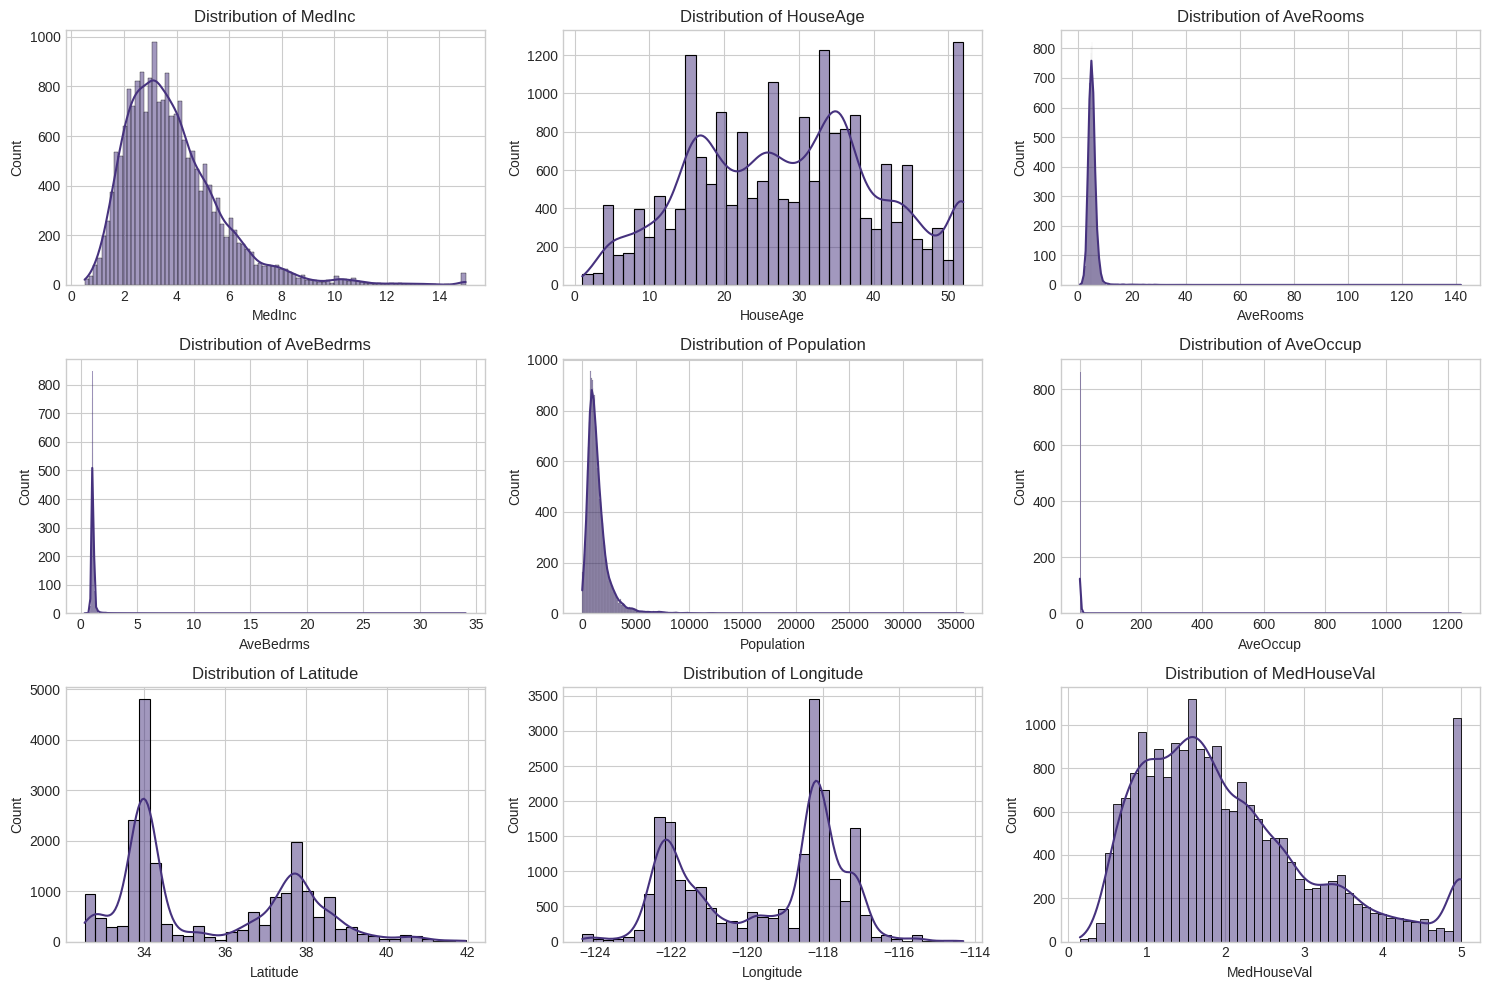

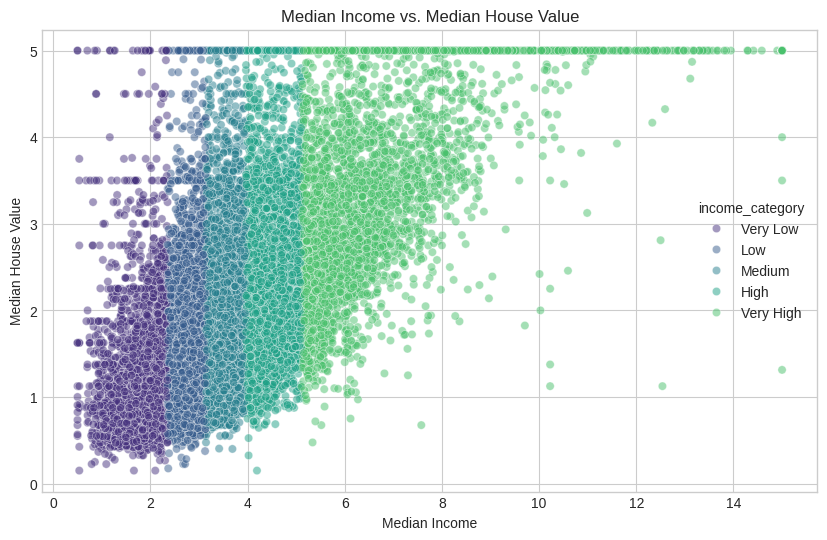

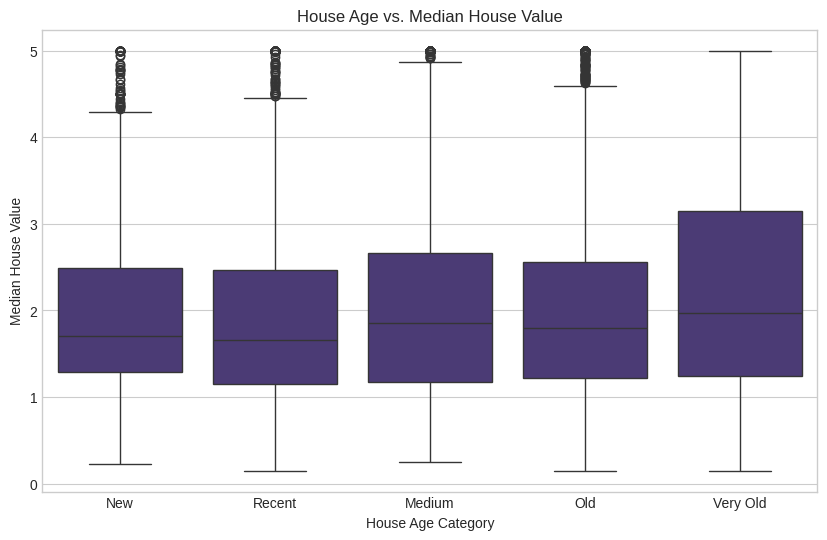

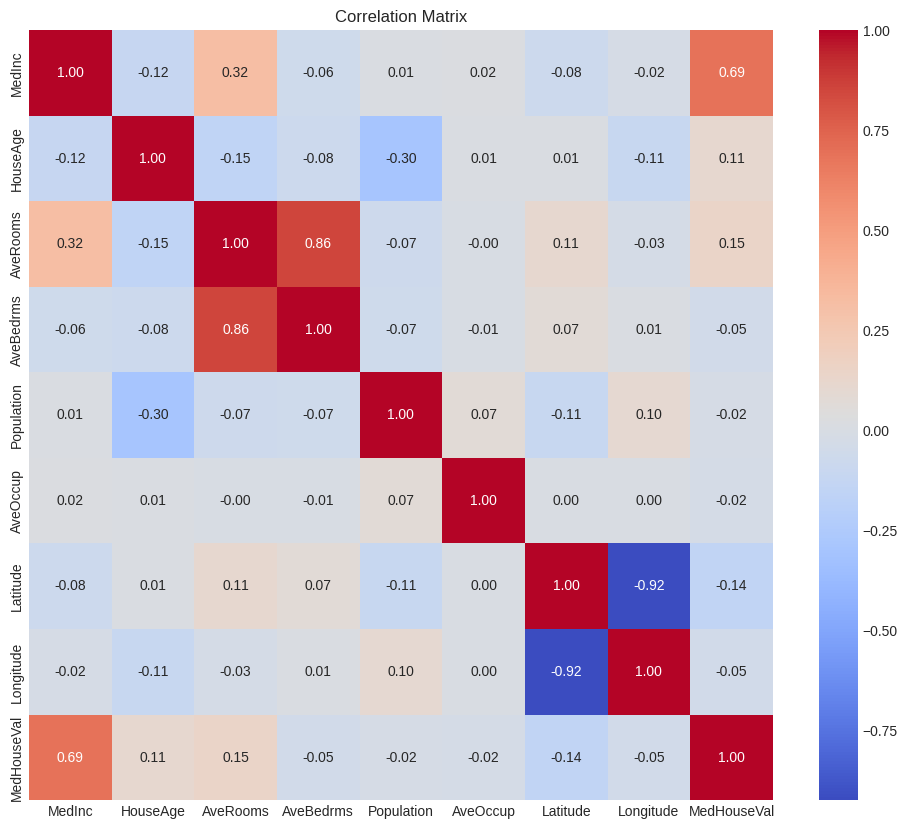

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Task 1: Data Acquisition & Cleanup (Unsupervised Preparation)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def load_data():
    """
    Load the California Housing dataset

    Returns:
        pandas.DataFrame: The loaded dataset
    """
    print("Loading California Housing dataset...")

    # Load the California Housing dataset
    california = fetch_california_housing(as_frame=True)

    # Create a DataFrame with the features and target
    df = california.frame

    # Add some categorical features for demonstration purposes
    # Binning median income into categories
    df['income_category'] = pd.qcut(df['MedInc'],
                                   q=5,
                                   labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    # Binning house age into categories
    df['age_category'] = pd.cut(df['HouseAge'],
                               bins=[0, 10, 20, 30, 40, np.inf],
                               labels=['New', 'Recent', 'Medium', 'Old', 'Very Old'])

    # Binning population into categories
    df['population_density'] = pd.qcut(df['Population'],
                                      q=3,
                                      labels=['Low', 'Medium', 'High'])

    # Introduce some missing values for demonstration purposes (about 5%)
    for col in df.columns[:5]:  # Only introduce missing values in some columns
        mask = np.random.random(len(df)) < 0.05
        df.loc[mask, col] = np.nan

    print(f"Dataset loaded with shape: {df.shape}")
    return df

def perform_eda(df):
    """
    Perform exploratory data analysis on the dataset

    Args:
        df (pandas.DataFrame): The dataset to analyze
    """
    print("\n--- Exploratory Data Analysis ---")

    # Display basic information about the dataset
    print("\nDataset Info:")
    print(df.info())

    # Display summary statistics
    print("\nSummary Statistics:")
    print(df.describe().round(2))

    # Check for missing values
    print("\nMissing Values:")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentage.round(2)
    })
    print(missing_df)

    # Visualize distributions of numerical features
    print("\nVisualizing distributions of numerical features...")

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(df.select_dtypes(include=np.number).columns):
        plt.subplot(3, 3, i+1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
    plt.savefig('numerical_distributions.png')

    # Visualize relationships between key features
    print("\nVisualizing relationships between key features...")

    # Relationship 1: Median Income vs. Median House Value
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='MedInc', y='MedHouseVal', data=df, alpha=0.5, hue='income_category')
    plt.title('Median Income vs. Median House Value')
    plt.xlabel('Median Income')
    plt.ylabel('Median House Value')
    plt.savefig('income_vs_house_value.png')

    # Relationship 2: House Age vs. Median House Value
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='age_category', y='MedHouseVal', data=df)
    plt.title('House Age vs. Median House Value')
    plt.xlabel('House Age Category')
    plt.ylabel('Median House Value')
    plt.savefig('age_vs_house_value.png')

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.select_dtypes(include=np.number).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')

    return

def clean_data(df):
    """
    Clean the dataset by handling missing values, encoding categorical variables,
    and normalizing numerical features

    Args:
        df (pandas.DataFrame): The dataset to clean

    Returns:
        pandas.DataFrame: The cleaned dataset
        sklearn.compose.ColumnTransformer: The preprocessing pipeline
    """
    print("\n--- Data Cleaning ---")

    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")

    # Create preprocessing pipelines for both numerical and categorical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Create a copy of the DataFrame for the cleaned version
    df_cleaned = df.copy()

    # Apply preprocessing to the data
    print("\nApplying preprocessing pipeline...")
    preprocessed_data = preprocessor.fit_transform(df_cleaned)

    # Get feature names after one-hot encoding
    onehot_cols = []
    if categorical_cols:
        onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        onehot_cols = onehot_encoder.get_feature_names_out(categorical_cols)

    # Create a new DataFrame with the preprocessed data
    all_feature_names = numerical_cols + onehot_cols.tolist()
    df_preprocessed = pd.DataFrame(
        preprocessed_data,
        columns=all_feature_names,
        index=df_cleaned.index
    )

    print(f"Cleaned dataset shape: {df_preprocessed.shape}")
    print(f"Number of features after preprocessing: {len(df_preprocessed.columns)}")

    return df_cleaned, df_preprocessed, preprocessor

def main():
    """
    Main function to execute Task 1
    """
    # Load the data
    df = load_data()

    # Perform exploratory data analysis
    perform_eda(df)

    # Clean the data
    df_cleaned, df_preprocessed, preprocessor = clean_data(df)

    # Save the cleaned data for later tasks
    df_cleaned.to_csv('california_housing_cleaned.csv', index=False)
    df_preprocessed.to_csv('california_housing_preprocessed.csv', index=False)

    print("\nTask 1 completed. Cleaned data saved to 'california_housing_cleaned.csv' and 'california_housing_preprocessed.csv'.")

if __name__ == "__main__":
    main()


Text 2

Loading preprocessed data...
Preprocessed data loaded with shape: (20640, 22)

--- Determining Optimal Number of Clusters ---
Testing k=2...
Silhouette Score for k=2: 0.2057
Testing k=3...
Silhouette Score for k=3: 0.2071
Testing k=4...
Silhouette Score for k=4: 0.2031
Testing k=5...
Silhouette Score for k=5: 0.1854
Testing k=6...
Silhouette Score for k=6: 0.1854
Testing k=7...
Silhouette Score for k=7: 0.1726
Testing k=8...
Silhouette Score for k=8: 0.1724
Testing k=9...
Silhouette Score for k=9: 0.1574
Testing k=10...
Silhouette Score for k=10: 0.1595

Optimal number of clusters based on silhouette score: 3

--- Applying K-Means Clustering with 3 clusters ---
K-Means clustering completed. Cluster distribution:
Cluster 0: 11788 samples (57.11%)
Cluster 1: 8781 samples (42.54%)
Cluster 2: 71 samples (0.34%)

--- Applying DBSCAN Clustering ---
Selected DBSCAN parameters: eps=0.6296, min_samples=10
DBSCAN clustering completed. Found 157 clusters and 8175 noise points.
Cluster distributio

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Visualizing DBSCAN Clusters using t-SNE ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Visualizing Agglomerative Clusters using t-SNE ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Characterizing K-Means Clusters ---


TypeError: agg function failed [how->mean,dtype->object]

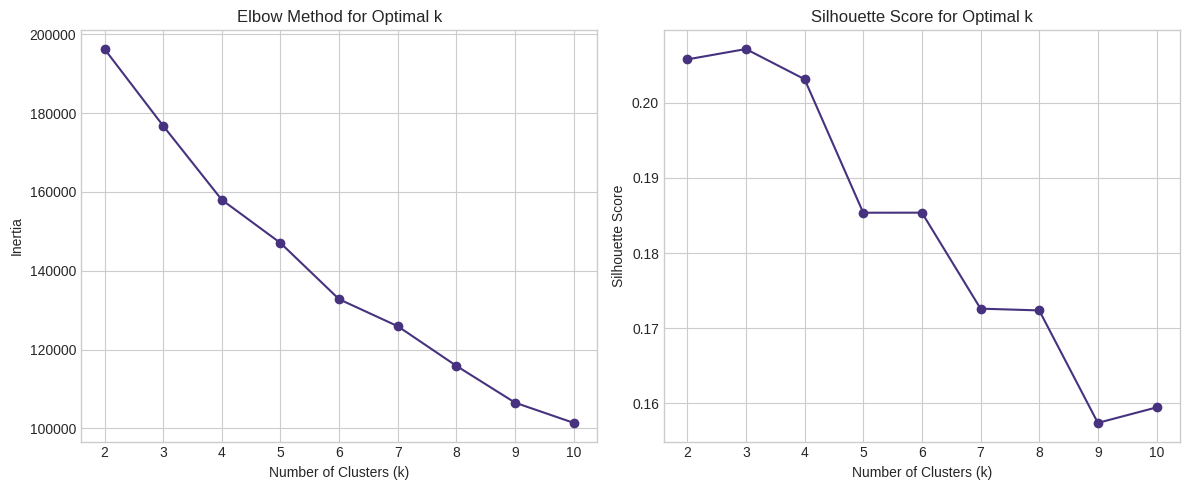

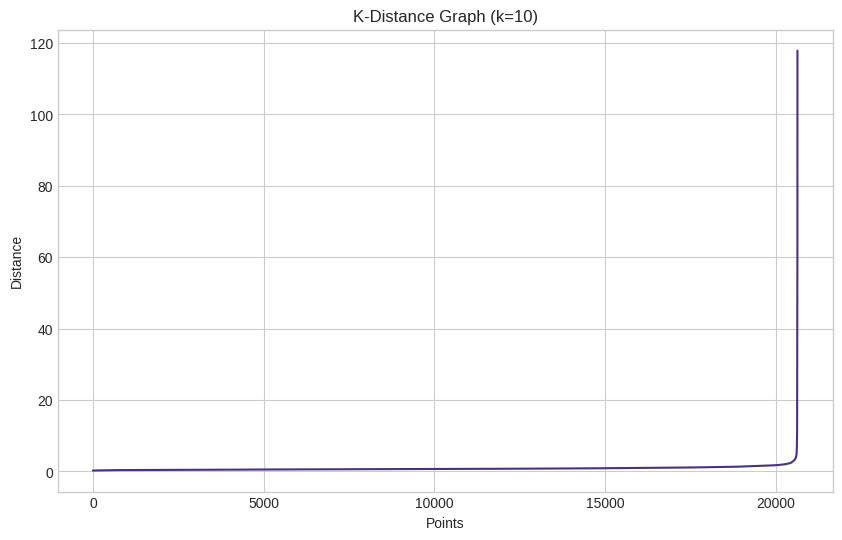

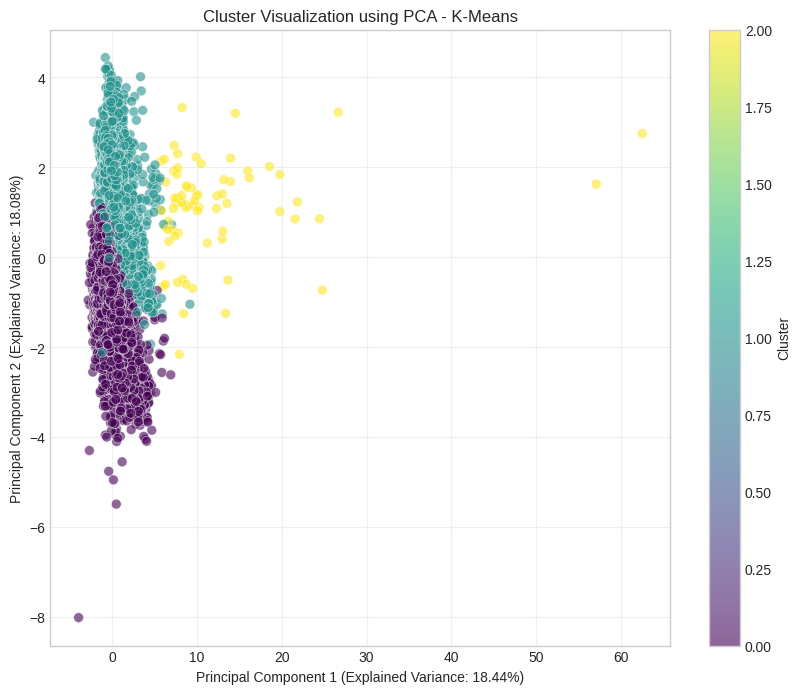

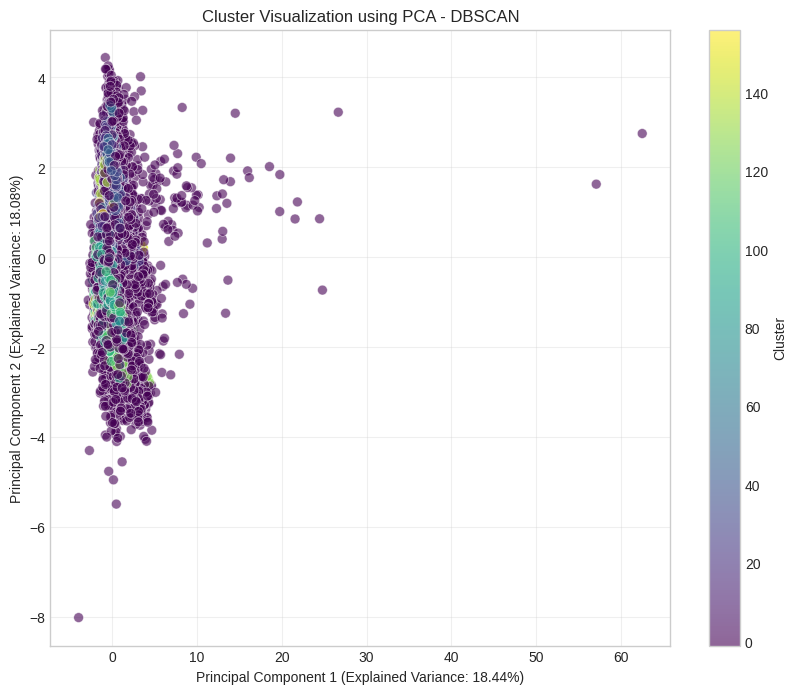

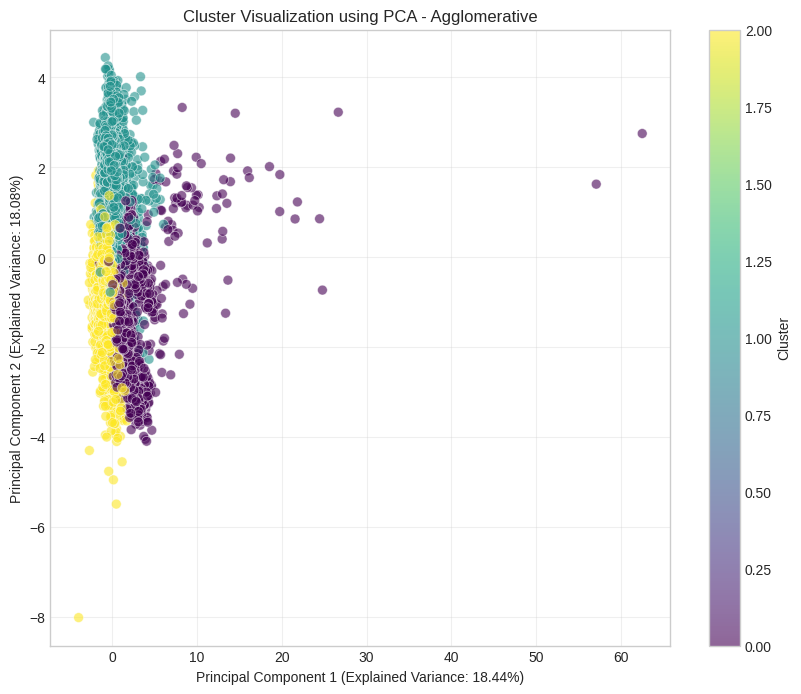

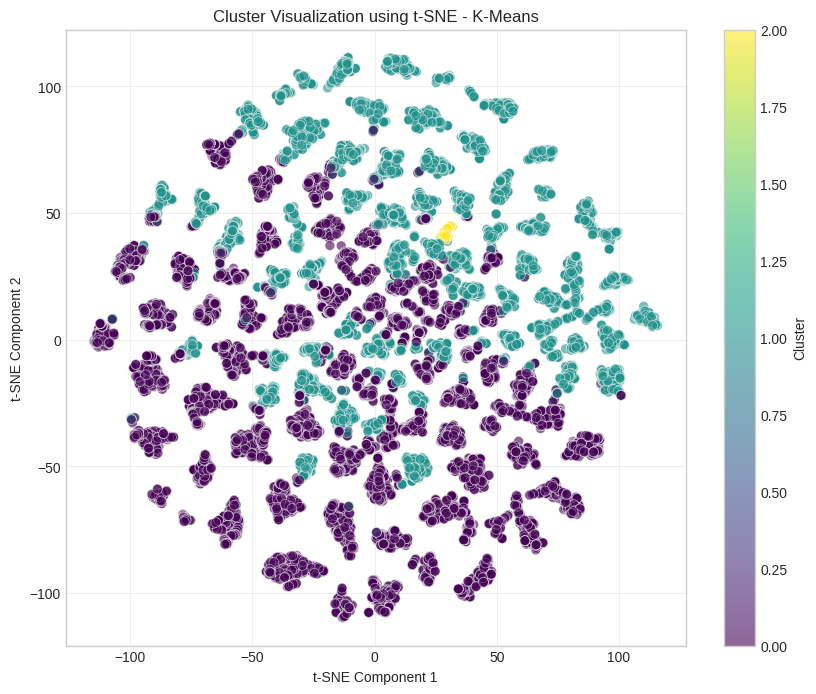

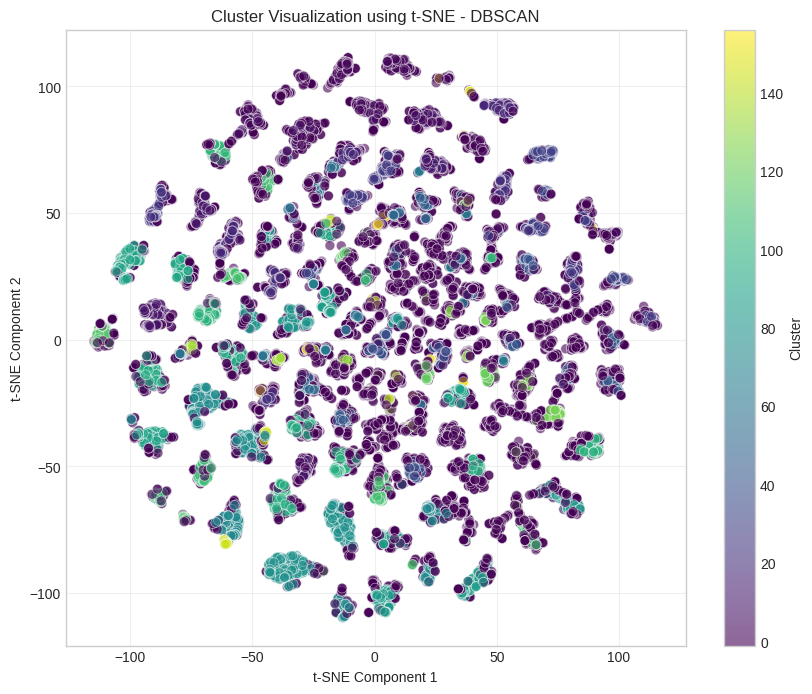

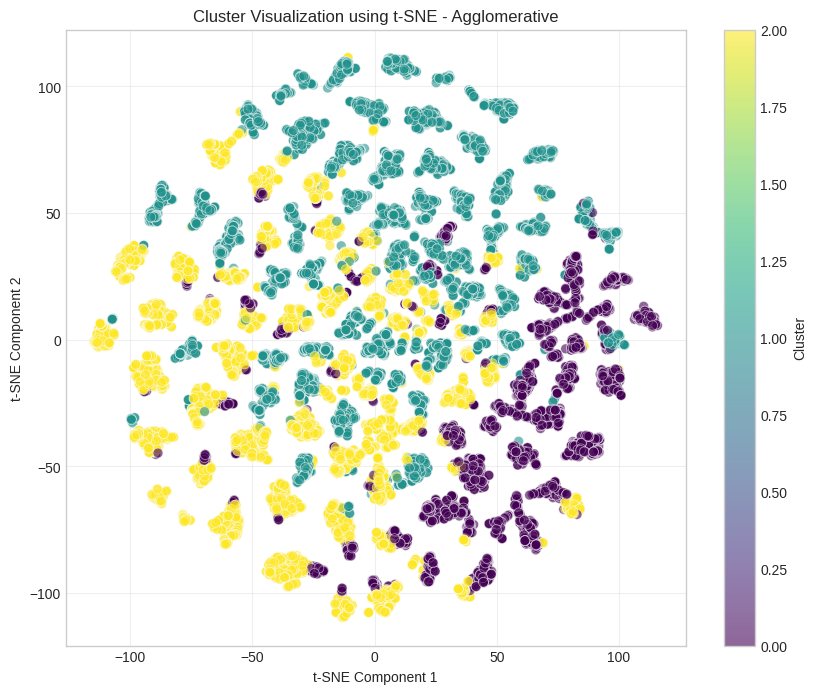

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Task 2: Unsupervised Learning (Clustering)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def load_preprocessed_data():
    """
    Load the preprocessed data from Task 1

    Returns:
        pandas.DataFrame: The preprocessed dataset
    """
    print("Loading preprocessed data...")
    try:
        df_preprocessed = pd.read_csv('california_housing_preprocessed.csv')
        print(f"Preprocessed data loaded with shape: {df_preprocessed.shape}")
        return df_preprocessed
    except FileNotFoundError:
        print("Preprocessed data file not found. Please run Task 1 first.")
        return None

def determine_optimal_clusters(data):
    """
    Determine the optimal number of clusters using the elbow method and silhouette score

    Args:
        data (numpy.ndarray): The data to cluster

    Returns:
        int: The optimal number of clusters
    """
    print("\n--- Determining Optimal Number of Clusters ---")

    # Calculate inertia (within-cluster sum of squares) for different k values
    inertia = []
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        print(f"Testing k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

        # Calculate silhouette score
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")

    # Plot the elbow method
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('optimal_clusters.png')

    # Find the optimal k based on silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")

    return optimal_k

def apply_kmeans(data, n_clusters):
    """
    Apply K-Means clustering to the data

    Args:
        data (numpy.ndarray): The data to cluster
        n_clusters (int): The number of clusters

    Returns:
        numpy.ndarray: The cluster labels
    """
    print(f"\n--- Applying K-Means Clustering with {n_clusters} clusters ---")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)

    print(f"K-Means clustering completed. Cluster distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for i, (cluster, count) in enumerate(zip(unique, counts)):
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return labels, kmeans

def apply_dbscan(data):
    """
    Apply DBSCAN clustering to the data

    Args:
        data (numpy.ndarray): The data to cluster

    Returns:
        numpy.ndarray: The cluster labels
    """
    print("\n--- Applying DBSCAN Clustering ---")

    # Determine eps using nearest neighbors
    from sklearn.neighbors import NearestNeighbors

    # Find optimal eps using k-distance graph
    neighbors = NearestNeighbors(n_neighbors=10)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    # Sort distances for k-distance graph
    distances = np.sort(distances[:, -1])

    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel('Distance')
    plt.title('K-Distance Graph (k=10)')
    plt.grid(True)
    plt.savefig('dbscan_kdistance.png')

    # Choose eps based on the "elbow" in the k-distance graph
    # For this example, we'll use a heuristic approach
    eps = np.percentile(distances, 90) * 0.5
    min_samples = 10

    print(f"Selected DBSCAN parameters: eps={eps:.4f}, min_samples={min_samples}")

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    # Count number of clusters (excluding noise points with label -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"DBSCAN clustering completed. Found {n_clusters} clusters and {n_noise} noise points.")
    print(f"Cluster distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for i, (cluster, count) in enumerate(zip(unique, counts)):
        if cluster == -1:
            print(f"Noise: {count} samples ({count/len(labels)*100:.2f}%)")
        else:
            print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return labels, dbscan

def apply_agglomerative(data, n_clusters):
    """
    Apply Agglomerative Clustering to the data

    Args:
        data (numpy.ndarray): The data to cluster
        n_clusters (int): The number of clusters

    Returns:
        numpy.ndarray: The cluster labels
    """
    print(f"\n--- Applying Agglomerative Clustering with {n_clusters} clusters ---")

    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = agg_clustering.fit_predict(data)

    print(f"Agglomerative clustering completed. Cluster distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for i, (cluster, count) in enumerate(zip(unique, counts)):
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return labels, agg_clustering

def visualize_clusters_pca(data, labels, algorithm_name):
    """
    Visualize clusters using PCA

    Args:
        data (numpy.ndarray): The data to visualize
        labels (numpy.ndarray): The cluster labels
        algorithm_name (str): The name of the clustering algorithm
    """
    print(f"\n--- Visualizing {algorithm_name} Clusters using PCA ---")

    # Apply PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Plot the clusters
    plt.figure(figsize=(10, 8))

    # Create a scatter plot
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis',
                         alpha=0.6, s=50, edgecolors='w', linewidths=0.5)

    # Add a colorbar
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title(f'Cluster Visualization using PCA - {algorithm_name}')
    plt.grid(True, alpha=0.3)

    plt.savefig(f'{algorithm_name.lower()}_pca_clusters.png')

    return reduced_data, pca

def visualize_clusters_tsne(data, labels, algorithm_name):
    """
    Visualize clusters using t-SNE

    Args:
        data (numpy.ndarray): The data to visualize
        labels (numpy.ndarray): The cluster labels
        algorithm_name (str): The name of the clustering algorithm
    """
    print(f"\n--- Visualizing {algorithm_name} Clusters using t-SNE ---")

    # Apply t-SNE to reduce dimensions to 2
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_data = tsne.fit_transform(data)

    # Plot the clusters
    plt.figure(figsize=(10, 8))

    # Create a scatter plot
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis',
                         alpha=0.6, s=50, edgecolors='w', linewidths=0.5)

    # Add a colorbar
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f'Cluster Visualization using t-SNE - {algorithm_name}')
    plt.grid(True, alpha=0.3)

    plt.savefig(f'{algorithm_name.lower()}_tsne_clusters.png')

    return reduced_data

def characterize_clusters(df_original, labels, algorithm_name):
    """
    Characterize clusters by profiling feature distributions per cluster

    Args:
        df_original (pandas.DataFrame): The original dataset
        labels (numpy.ndarray): The cluster labels
        algorithm_name (str): The name of the clustering algorithm
    """
    print(f"\n--- Characterizing {algorithm_name} Clusters ---")

    # Add cluster labels to the original dataframe
    df_with_clusters = df_original.copy()
    df_with_clusters['Cluster'] = labels

    # For each cluster, calculate the mean of each feature
    # Select only numerical columns before calculating the mean
    numerical_cols = df_with_clusters.select_dtypes(include=np.number).columns.tolist()
    cluster_means = df_with_clusters[numerical_cols + ['Cluster']].groupby('Cluster').mean()

    print("\nCluster Means:")
    print(cluster_means)

    # Create a heatmap of cluster means
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Feature Means by Cluster - {algorithm_name}')
    plt.savefig(f'{algorithm_name.lower()}_cluster_means.png')

    # For numerical features, create box plots to compare distributions across clusters
    numerical_cols_original = df_original.select_dtypes(include=np.number).columns.tolist()

    for col in numerical_cols_original[:5]:  # Limit to first 5 numerical columns for brevity
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster', y=col, data=df_with_clusters)
        plt.title(f'Distribution of {col} by Cluster - {algorithm_name}')
        plt.savefig(f'{algorithm_name.lower()}_cluster_{col}_boxplot.png')

    return df_with_clusters, cluster_means

def write_cluster_report(kmeans_report, dbscan_report):
    """
    Write a brief report on insights gained from the clusters

    Args:
        kmeans_report (tuple): The dataframe with clusters and cluster means from K-Means
        dbscan_report (tuple): The dataframe with clusters and cluster means from DBSCAN
    """
    print("\n--- Writing Cluster Analysis Report ---")

    kmeans_df, kmeans_means = kmeans_report
    dbscan_df, dbscan_means = dbscan_report

    report = """
# Cluster Analysis Report

## Overview
This report presents insights gained from applying clustering algorithms to the California Housing dataset.
We applied two different clustering algorithms: K-Means and DBSCAN, to identify natural groupings in the data.

## K-Means Clustering Insights

K-Means clustering revealed distinct housing market segments based on various features:

"""

    # Add insights from K-Means clustering
    for cluster in kmeans_means.index:
        report += f"### Cluster {cluster}:\n"

        # Get the top 3 highest and lowest features for this cluster
        highest = kmeans_means.loc[cluster].nlargest(3)
        lowest = kmeans_means.loc[cluster].nsmallest(3)

        report += "**Key characteristics:**\n"
        report += "- High values in: " + ", ".join([f"{col} ({val:.2f})" for col, val in highest.items()]) + "\n"
        report += "- Low values in: " + ", ".join([f"{col} ({val:.2f})" for col, val in lowest.items()]) + "\n\n"

    report += """
## DBSCAN Clustering Insights

DBSCAN identified clusters of varying density and also detected outliers (noise points):

"""

    # Add insights from DBSCAN clustering
    for cluster in dbscan_means.index:
        if cluster == -1:
            report += "### Noise Points (Outliers):\n"
        else:
            report += f"### Cluster {cluster}:\n"

        # Get the top 3 highest and lowest features for this cluster
        highest = dbscan_means.loc[cluster].nlargest(3)
        lowest = dbscan_means.loc[cluster].nsmallest(3)

        report += "**Key characteristics:**\n"
        report += "- High values in: " + ", ".join([f"{col} ({val:.2f})" for col, val in highest.items()]) + "\n"
        report += "- Low values in: " + ", ".join([f"{col} ({val:.2f})" for col, val in lowest.items()]) + "\n\n"

    report += """
## Comparison and Conclusions

The clustering analysis revealed several important insights about the California housing market:

1. **Geographic Segmentation**: Both algorithms identified clusters that correspond to different geographic regions with distinct housing characteristics.

2. **Income-Housing Value Relationship**: There is a strong correlation between median income and housing values across clusters, confirming the importance of income as a predictor of housing prices.

3. **Urban vs. Rural Divide**: Some clusters clearly represent urban areas (high population density, higher housing values) while others represent more rural areas.

4. **Age Impact**: House age has varying impacts on housing values depending on the region, suggesting that older houses may be more valuable in certain areas (possibly historic districts) but less valuable in others.

5. **Outlier Properties**: DBSCAN identified outlier properties that don't fit well into any cluster, which could represent unique housing markets or data anomalies worth investigating further.

These insights can help inform housing policy, investment decisions, and further predictive modeling efforts.
"""

    # Write the report to a file
    with open('cluster_analysis_report.md', 'w') as f:
        f.write(report)

    print("Cluster analysis report written to 'cluster_analysis_report.md'")

    return report

def main():

    df_preprocessed = load_preprocessed_data()
    if df_preprocessed is None:
        return

    try:
        df_cleaned = pd.read_csv('california_housing_cleaned.csv')
    except FileNotFoundError:
        print("Cleaned data file not found. Please run Task 1 first.")
        return

    data = df_preprocessed.values

    optimal_k = determine_optimal_clusters(data)

    kmeans_labels, kmeans_model = apply_kmeans(data, optimal_k)

    dbscan_labels, dbscan_model = apply_dbscan(data)

    agg_labels, agg_model = apply_agglomerative(data, optimal_k)

    visualize_clusters_pca(data, kmeans_labels, 'K-Means')
    visualize_clusters_pca(data, dbscan_labels, 'DBSCAN')
    visualize_clusters_pca(data, agg_labels, 'Agglomerative')

    visualize_clusters_tsne(data, kmeans_labels, 'K-Means')
    visualize_clusters_tsne(data, dbscan_labels, 'DBSCAN')
    visualize_clusters_tsne(data, agg_labels, 'Agglomerative')

    # Characterize clusters
    kmeans_report = characterize_clusters(df_cleaned, kmeans_labels, 'K-Means')
    dbscan_report = characterize_clusters(df_cleaned, dbscan_labels, 'DBSCAN')
    agg_report = characterize_clusters(df_cleaned, agg_labels, 'Agglomerative')

    # Write cluster analysis report
    write_cluster_report(kmeans_report, dbscan_report)

    print("\nTask 2 completed.")

if __name__ == "__main__":
    main()

Loading preprocessed data...
Preprocessed data loaded with shape: (20640, 22)

--- Determining Optimal Number of Clusters ---
Testing k=2...
Silhouette Score for k=2: 0.2057
Testing k=3...
Silhouette Score for k=3: 0.2071
Testing k=4...
Silhouette Score for k=4: 0.2031
Testing k=5...
Silhouette Score for k=5: 0.1854
Testing k=6...
Silhouette Score for k=6: 0.1854
Testing k=7...
Silhouette Score for k=7: 0.1726
Testing k=8...
Silhouette Score for k=8: 0.1724
Testing k=9...
Silhouette Score for k=9: 0.1574
Testing k=10...
Silhouette Score for k=10: 0.1595

Optimal number of clusters based on silhouette score: 3

--- Applying K-Means Clustering with 3 clusters ---
K-Means clustering completed. Cluster distribution:
Cluster 0: 11788 samples (57.11%)
Cluster 1: 8781 samples (42.54%)
Cluster 2: 71 samples (0.34%)

--- Applying DBSCAN Clustering ---
Selected DBSCAN parameters: eps=0.6296, min_samples=10
DBSCAN clustering completed. Found 157 clusters and 8175 noise points.
Cluster distributio

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Visualizing DBSCAN Clusters using t-SNE ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Visualizing Agglomerative Clusters using t-SNE ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Characterizing K-Means Clusters ---

Cluster Means:
           MedInc   HouseAge   AveRooms  AveBedrms   Population  AveOccup  \
Cluster                                                                     
0        3.935150  28.498527   5.210044   1.071693  1538.934061  3.097243   
1        3.786472  28.986553   5.498803   1.082819  1285.070975  3.039729   
2        3.256847  18.246377  32.623318   6.871912   249.575758  2.481060   

          Latitude   Longitude  MedHouseVal  
Cluster                                      
0        33.913924 -117.990937     2.157331  
1        37.920591 -121.689957     1.953104  
2        37.796761 -119.465070     1.608648  

--- Characterizing DBSCAN Clusters ---

Cluster Means:
           MedInc   HouseAge  AveRooms  AveBedrms   Population  AveOccup  \
Cluster                                                                    
-1       4.222153  24.010553  5.945317   1.177673  1617.803058  3.179085   
 0       4.437178  48.084034  5.553096   1.

/tmp/ipython-input-3-137652117.py:299: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
/tmp/ipython-input-3-137652117.py:318: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipython-input-3-137652117.py:318: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipython-input-3-137652117.py:318: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



--- Characterizing Agglomerative Clusters ---

Cluster Means:
           MedInc   HouseAge  AveRooms  AveBedrms   Population  AveOccup  \
Cluster                                                                    
0        6.285013  26.496622  6.918645   1.156756  1246.895587  2.788296   
1        3.228009  29.649215  5.332326   1.103372  1193.385751  2.780041   
2        3.217069  28.888682  4.761994   1.061601  1731.812469  3.480500   

          Latitude   Longitude  MedHouseVal  
Cluster                                      
0        35.066778 -119.274106     3.447103  
1        37.787201 -121.478364     1.686242  
2        33.953399 -117.978507     1.711962  

--- Writing Cluster Analysis Report ---
Cluster analysis report written to 'cluster_analysis_report.md'

Task 2 completed.


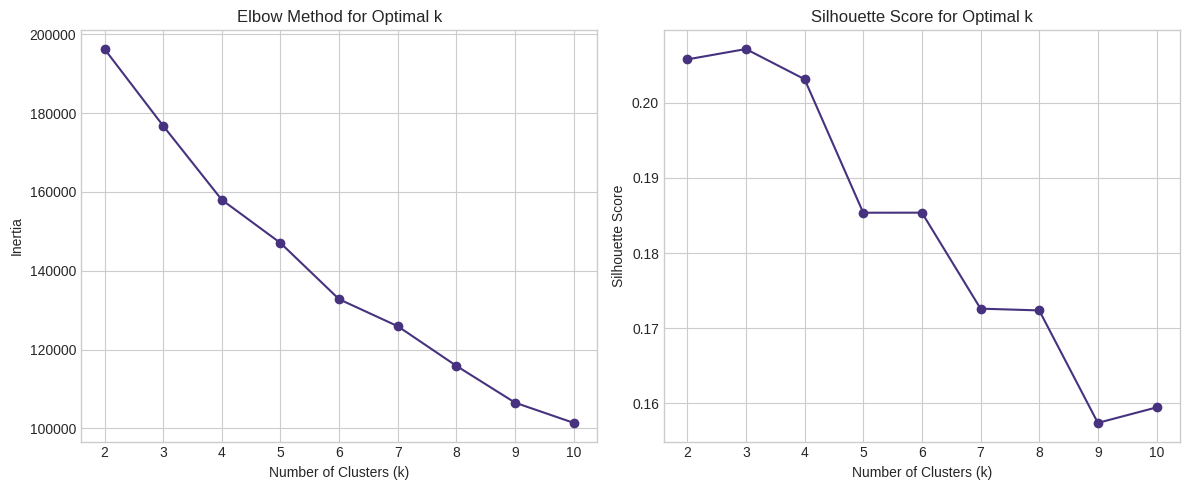

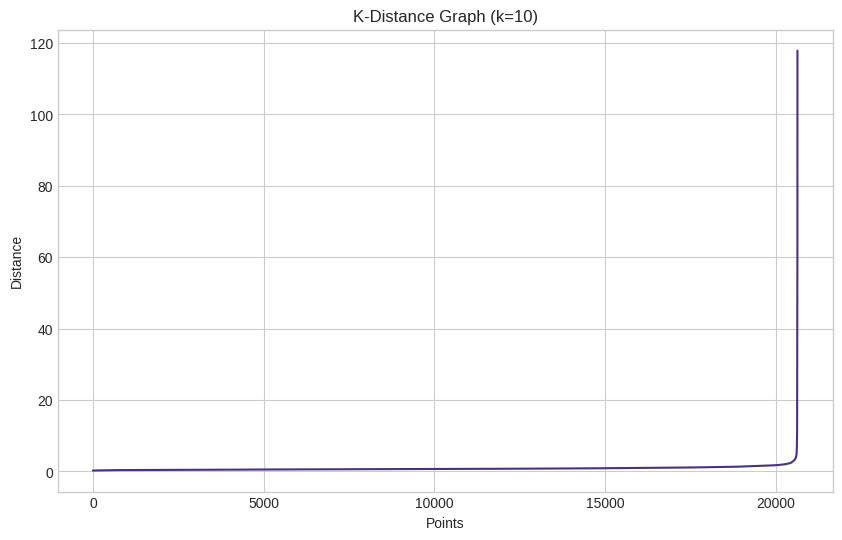

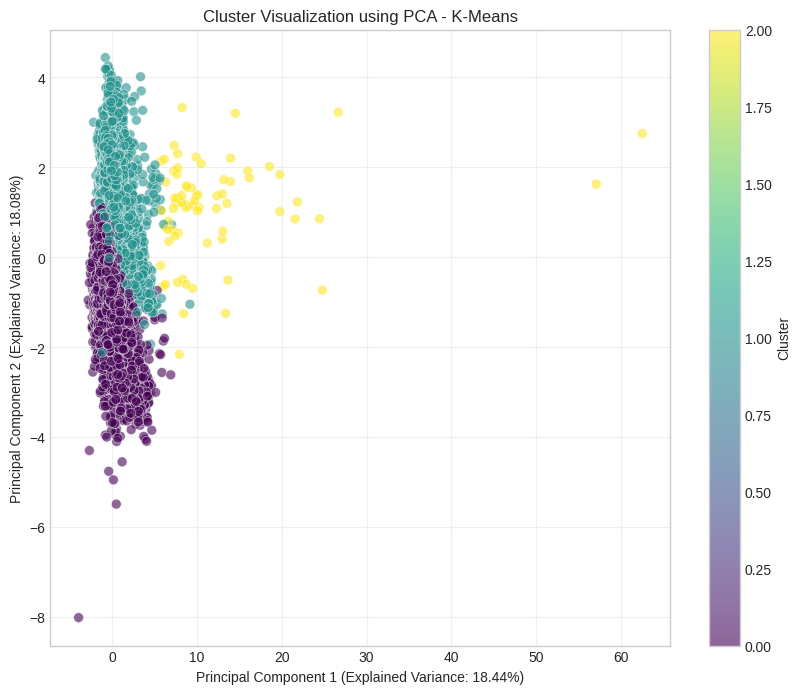

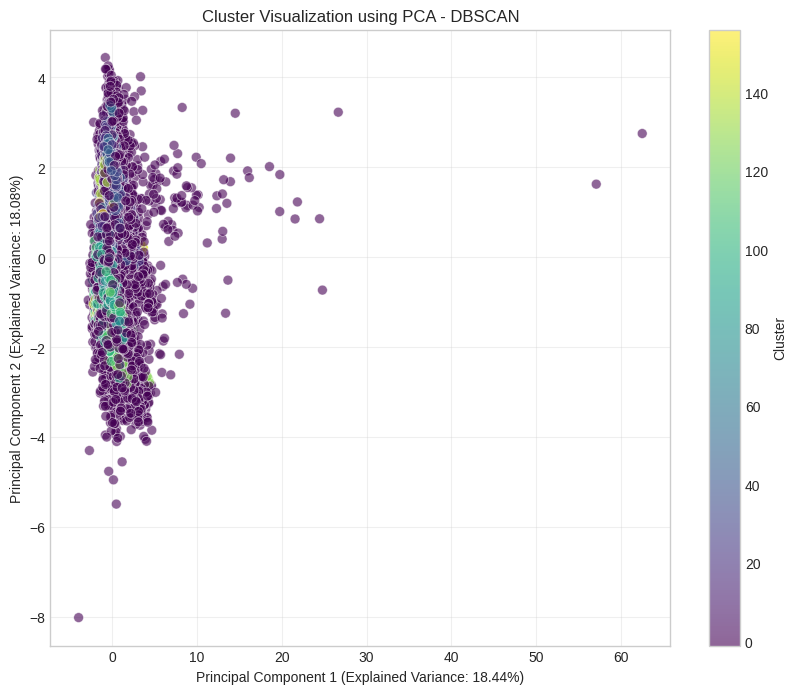

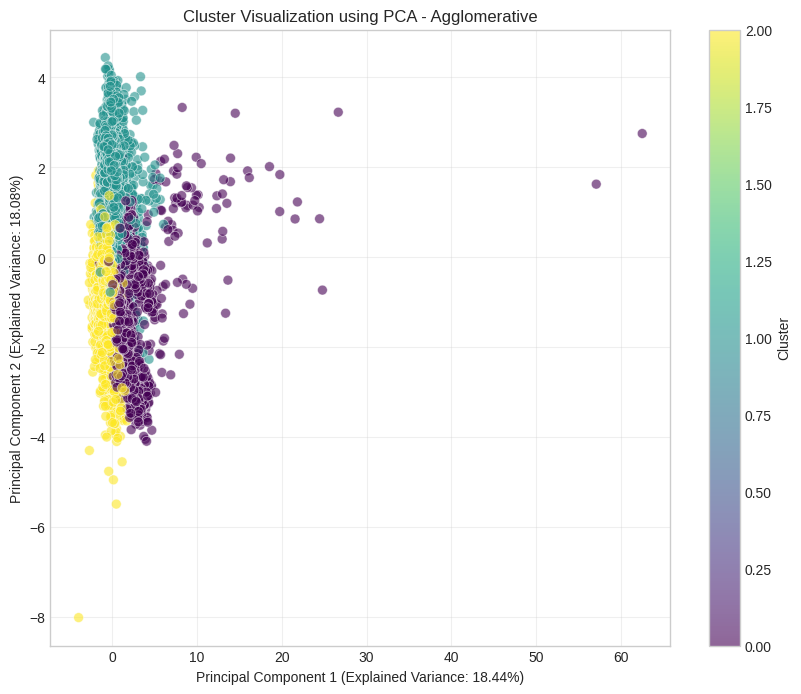

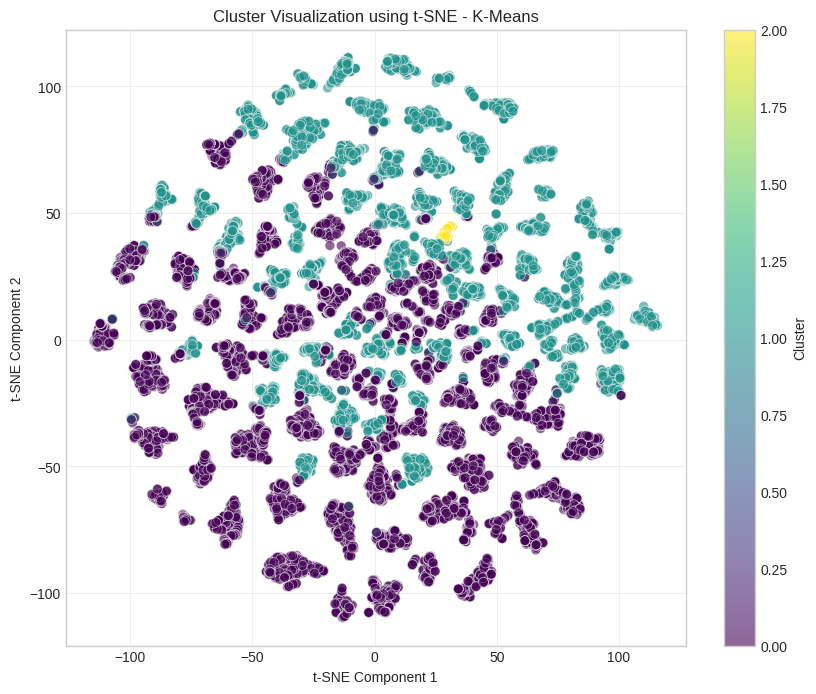

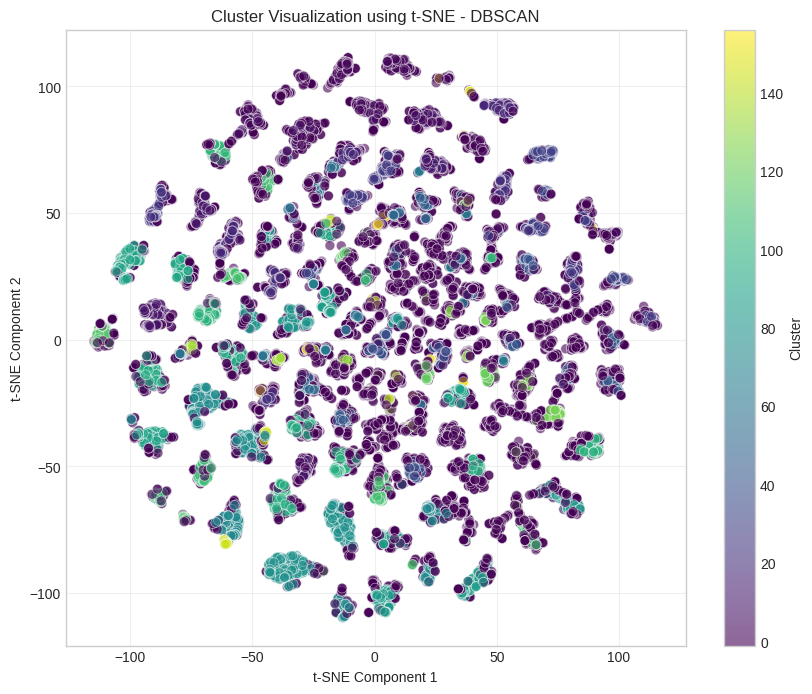

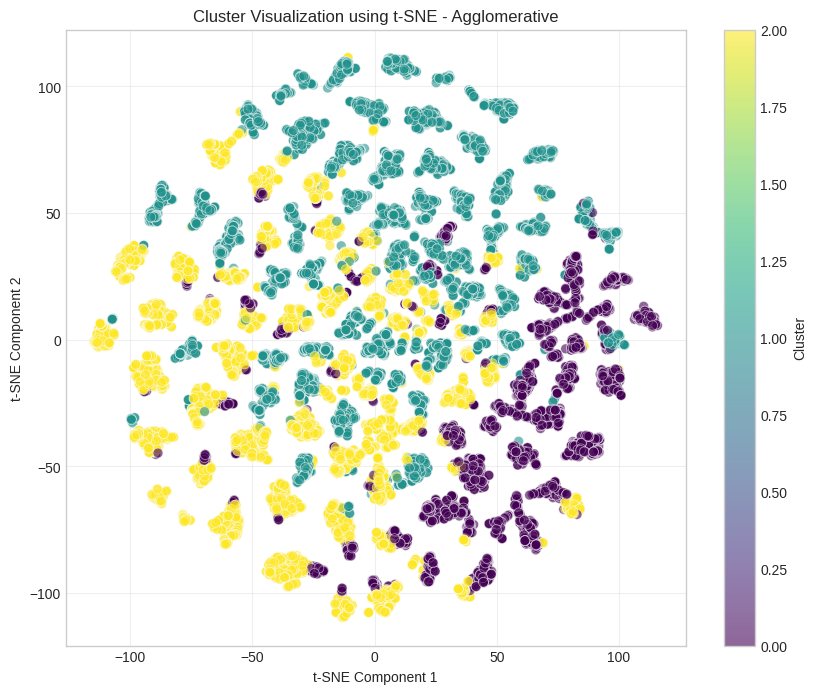

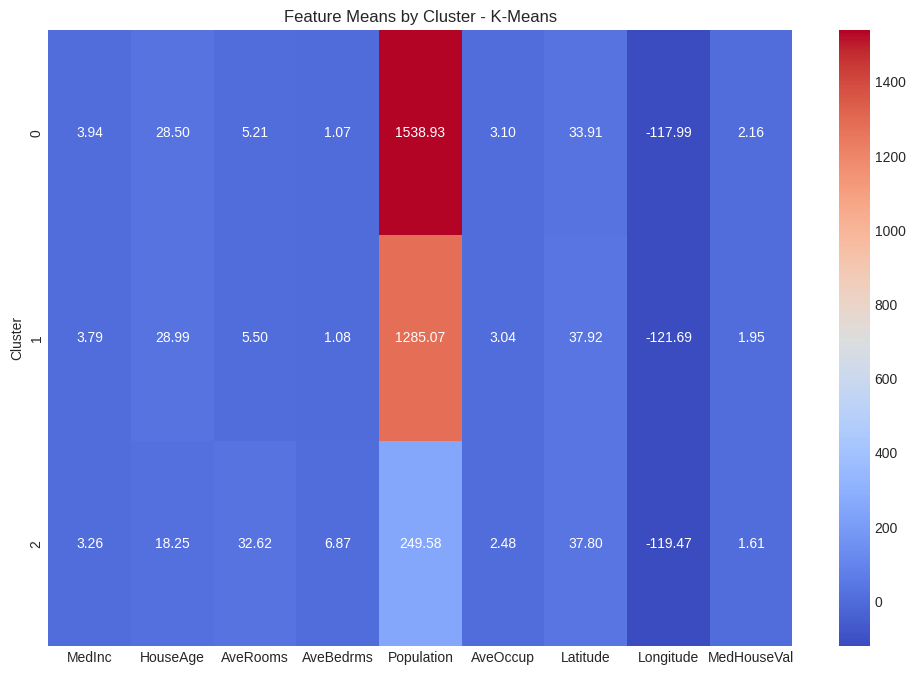

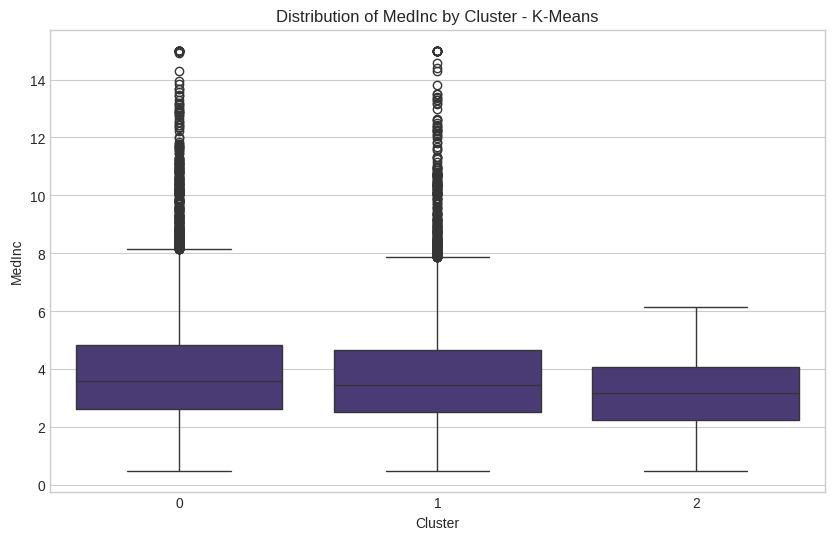

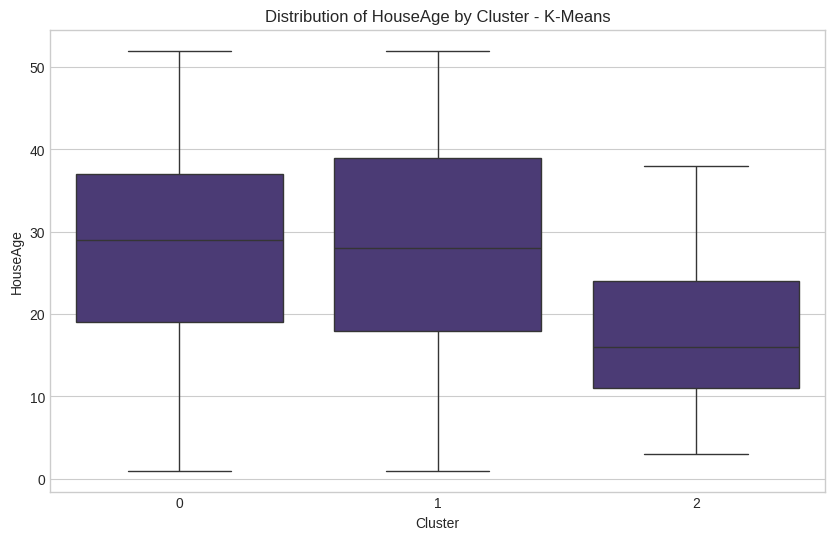

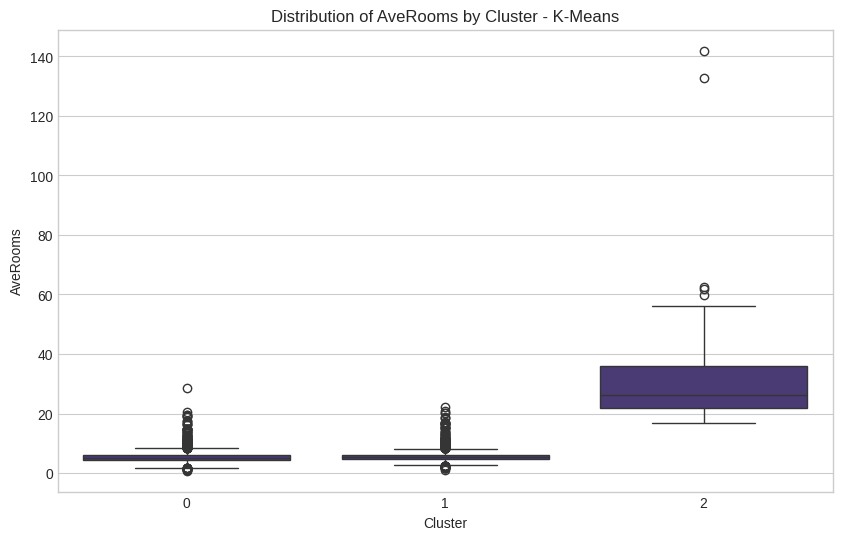

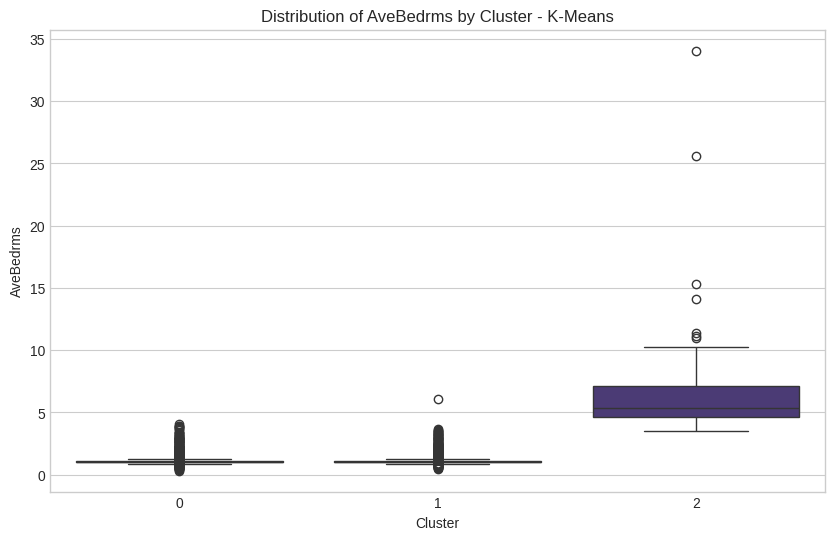

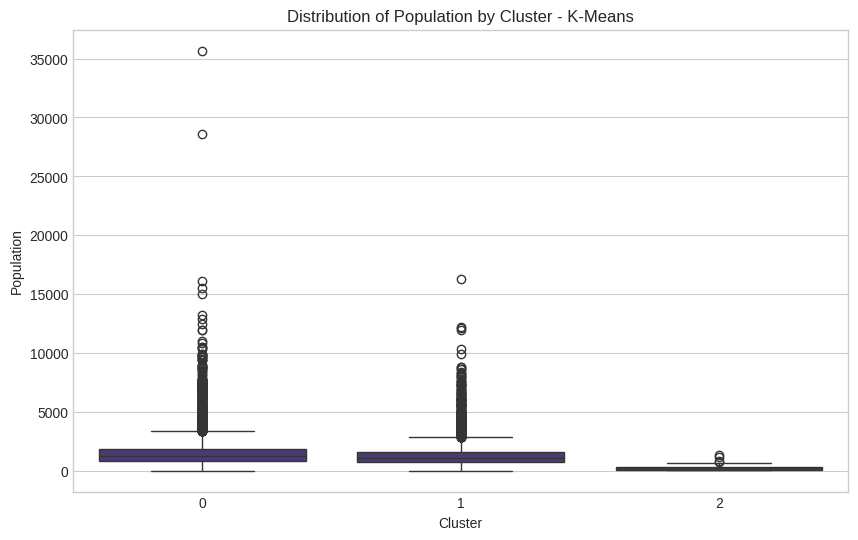

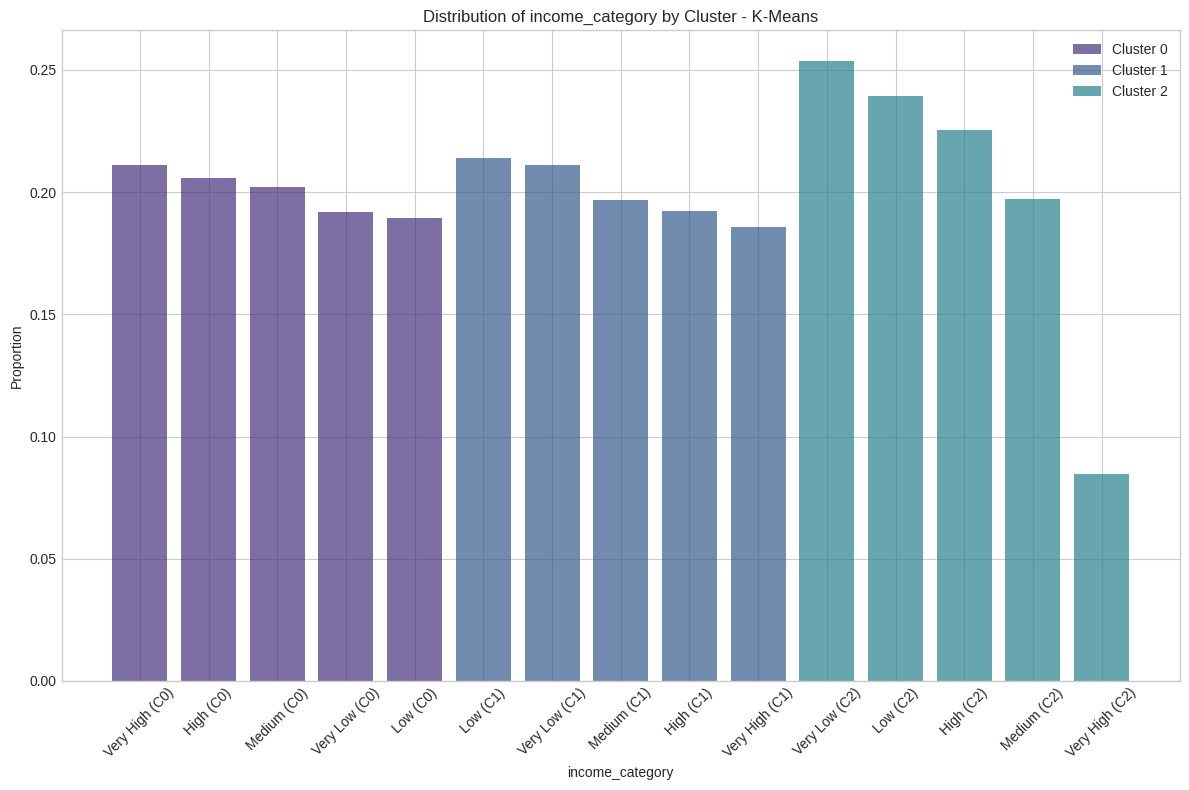

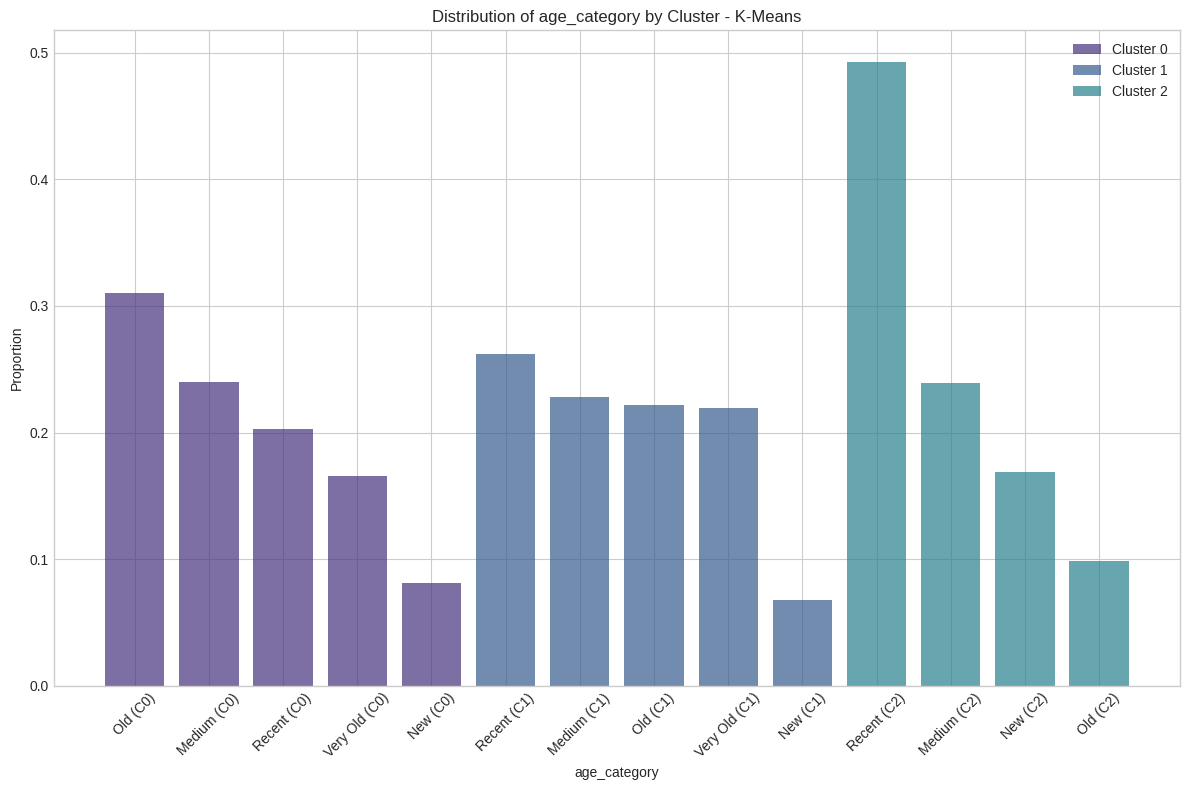

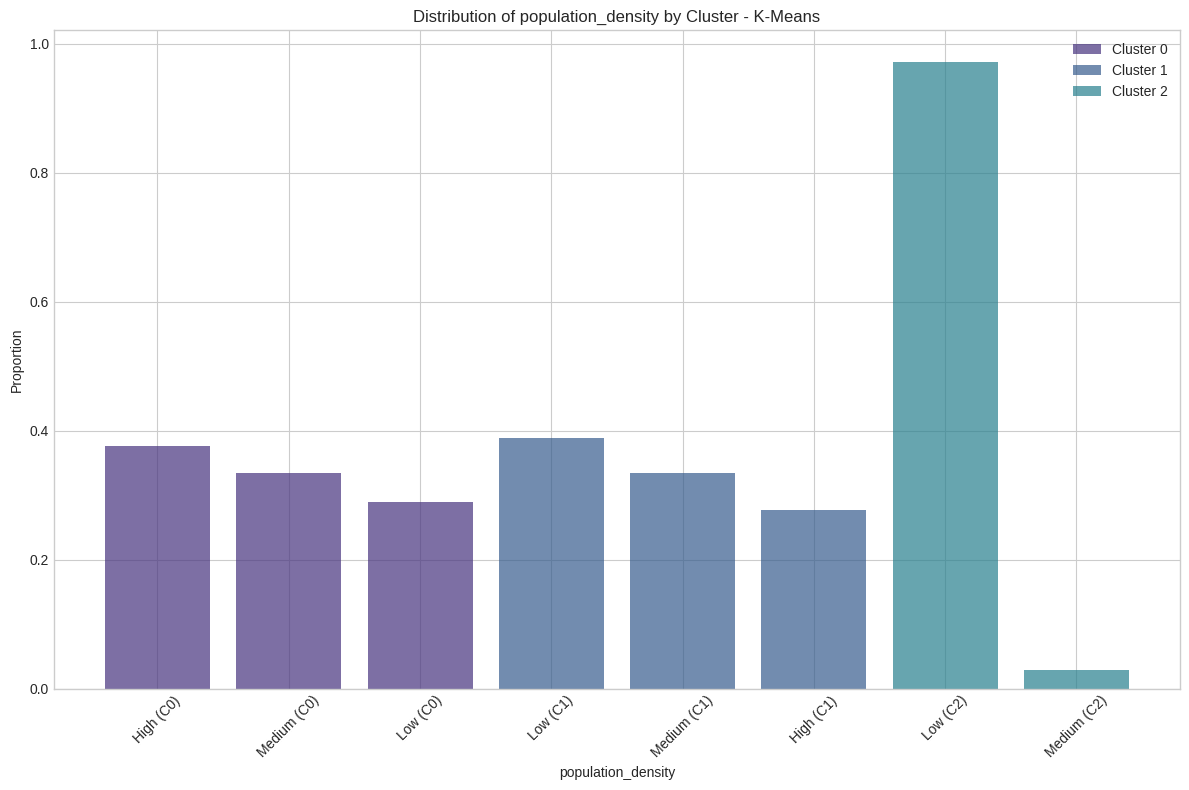

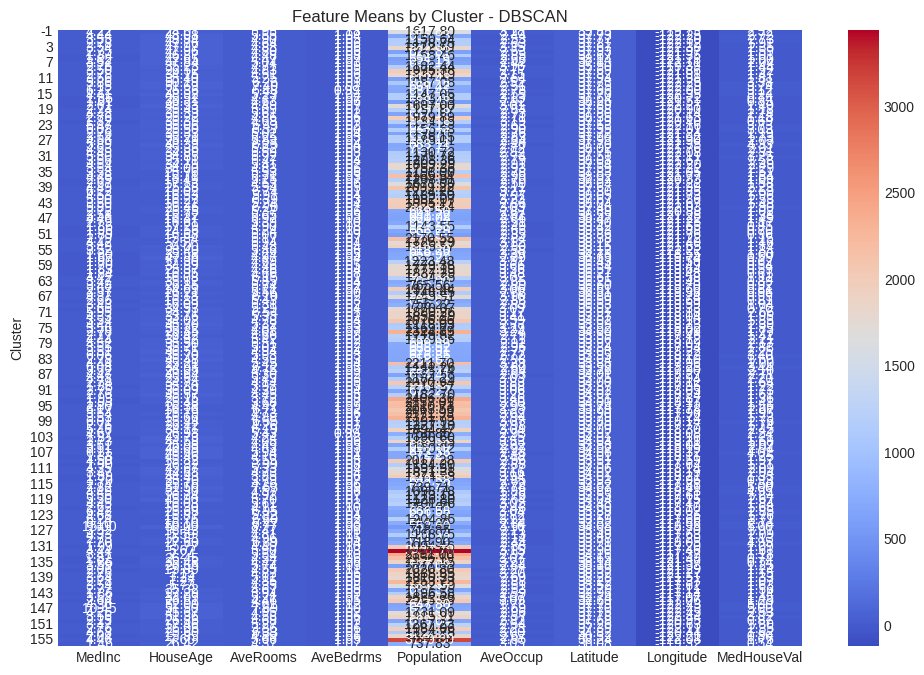

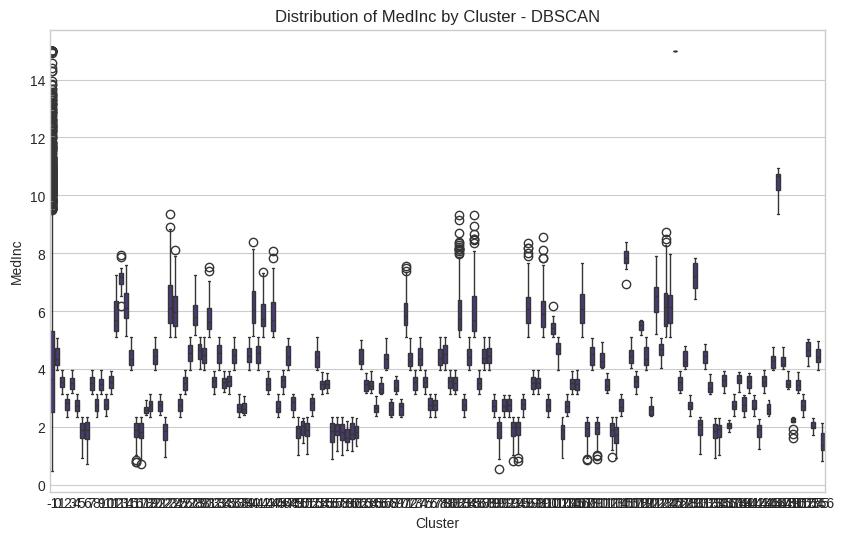

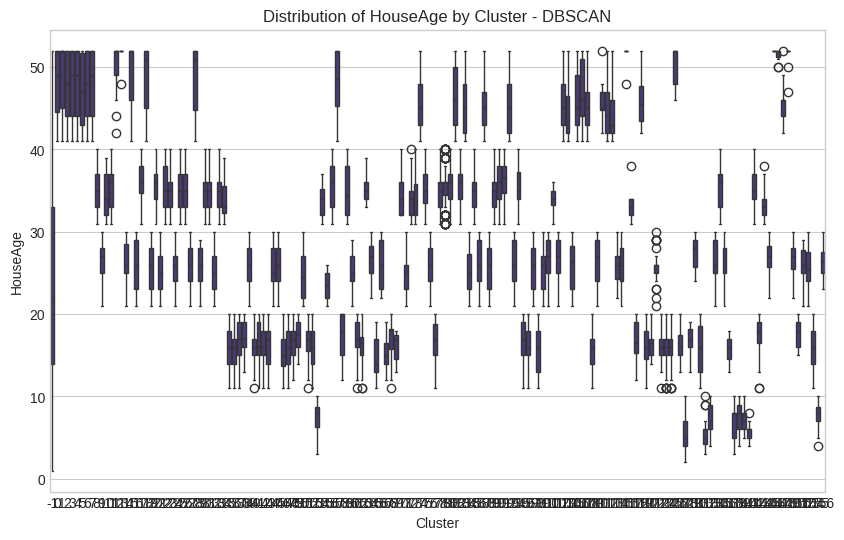

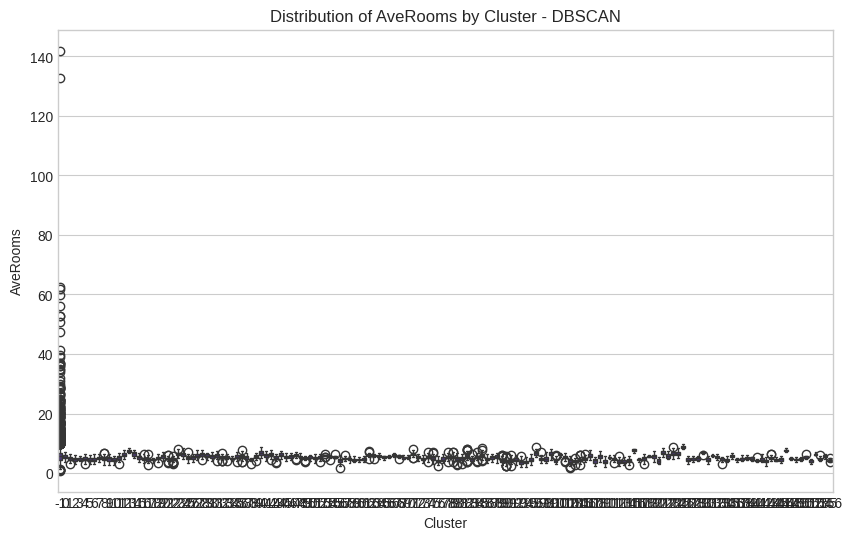

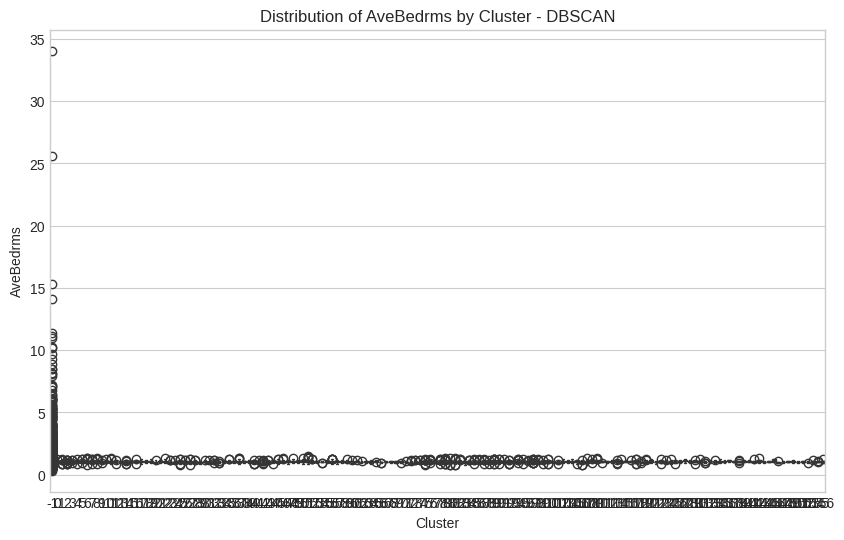

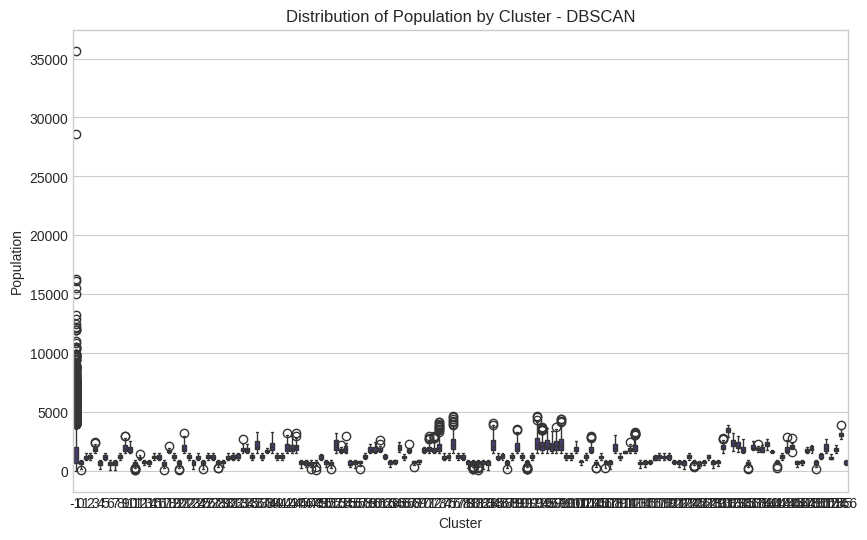

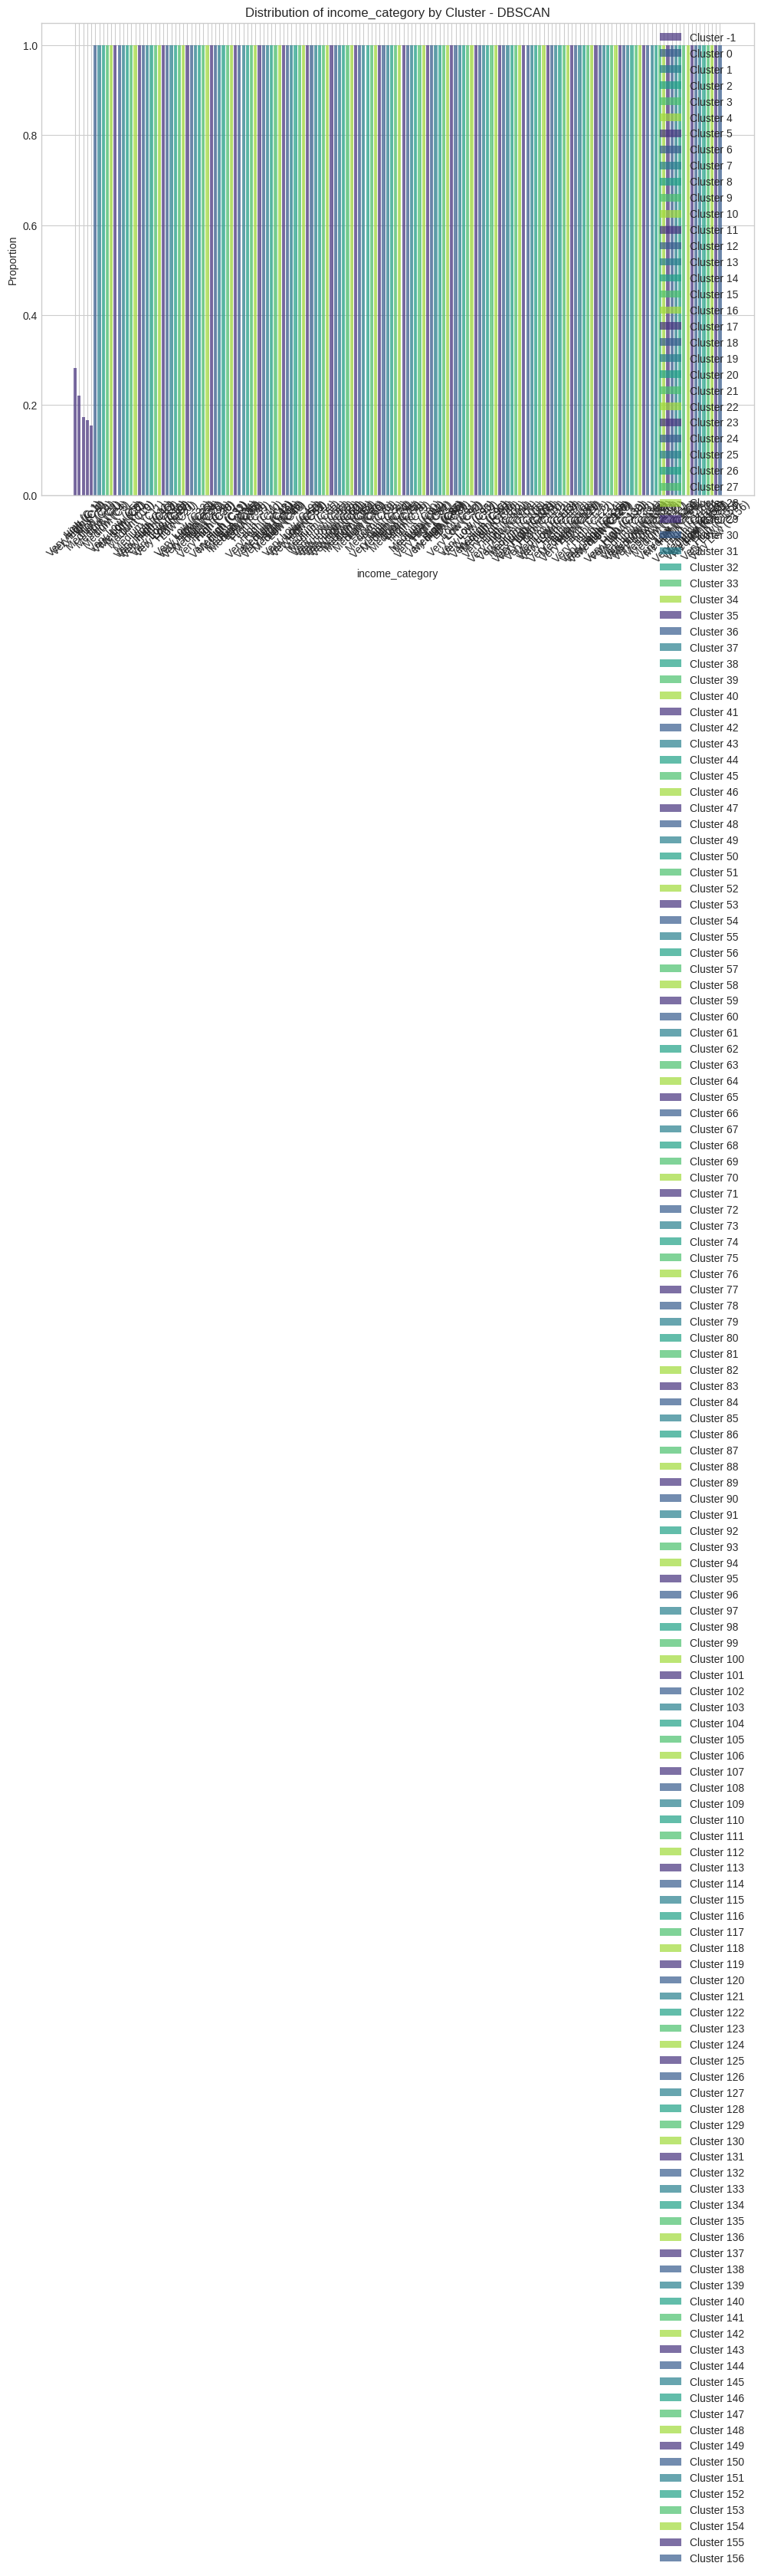

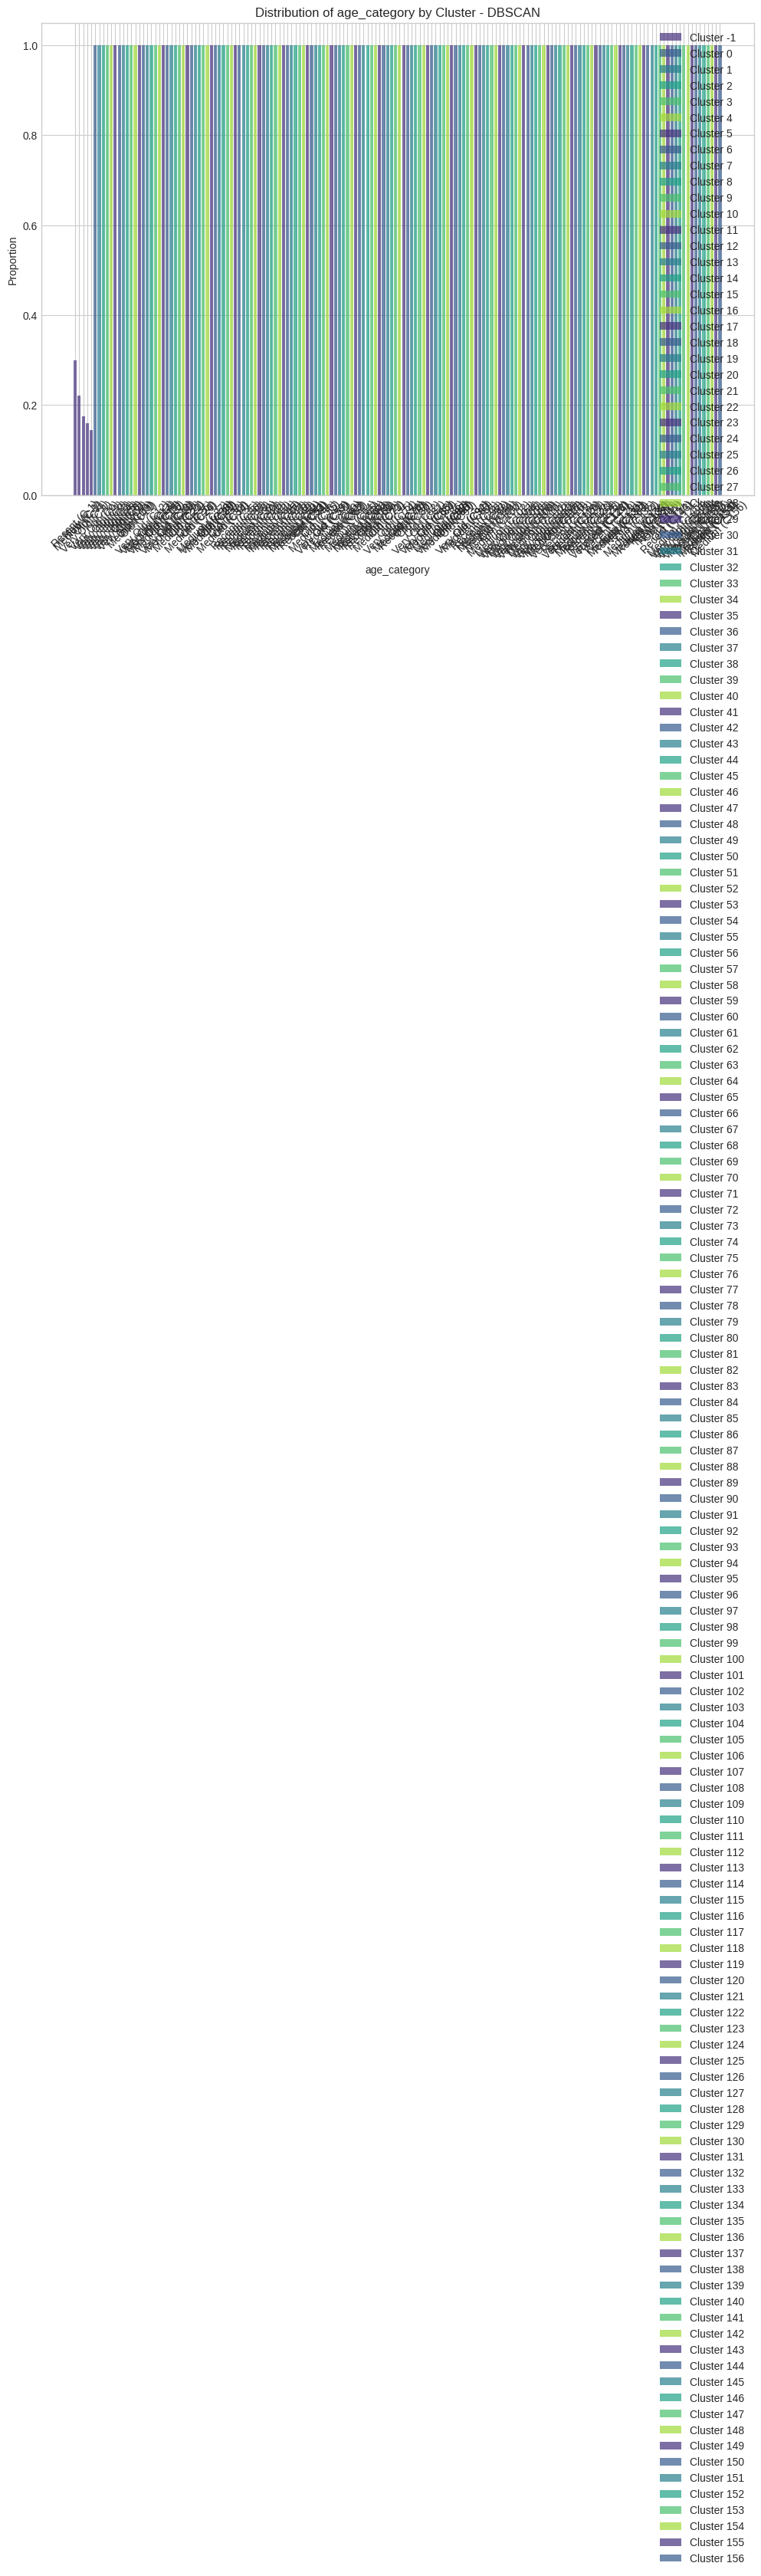

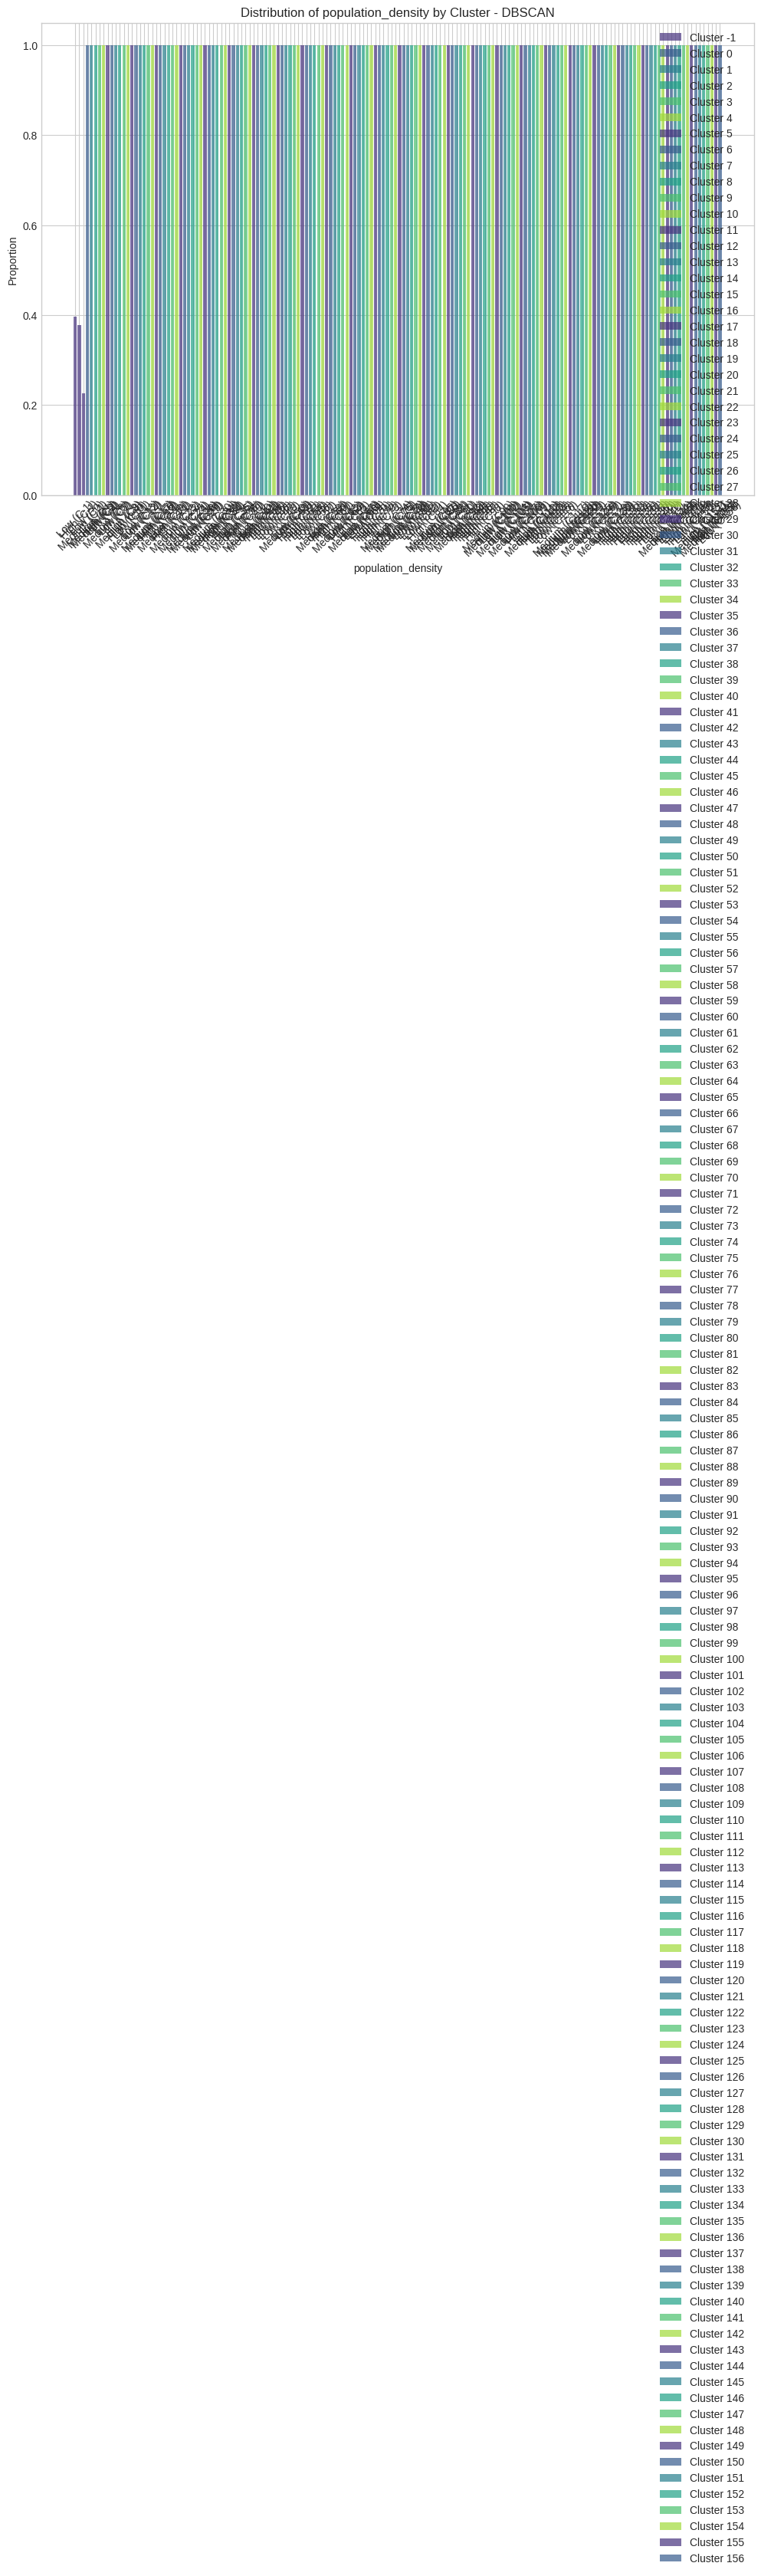

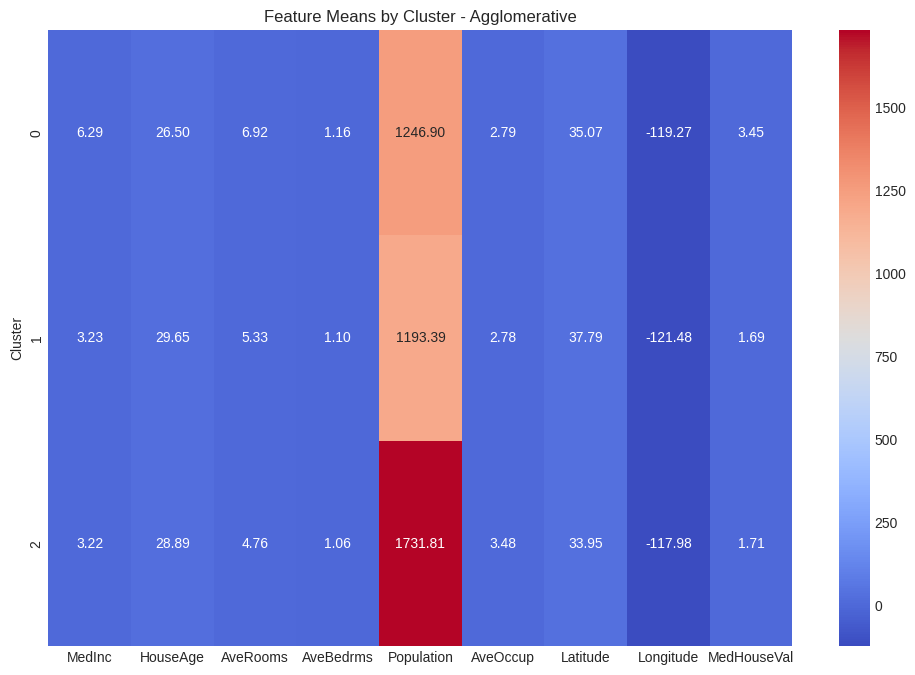

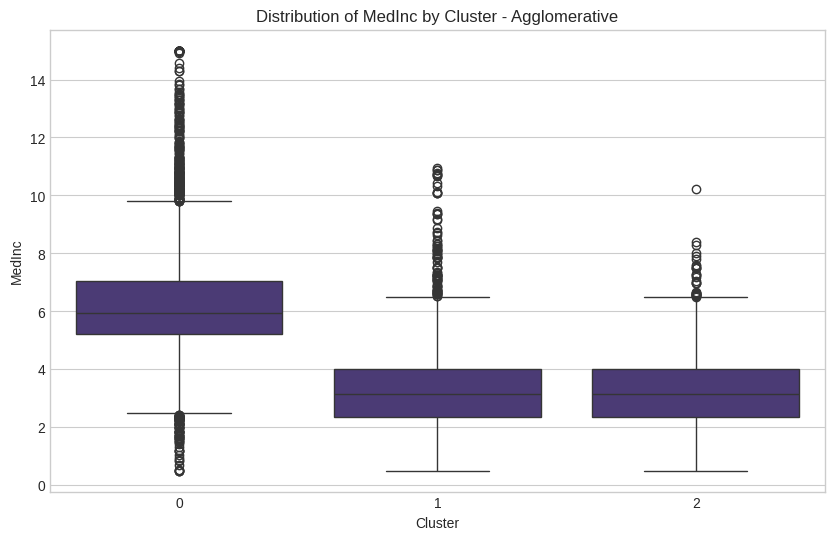

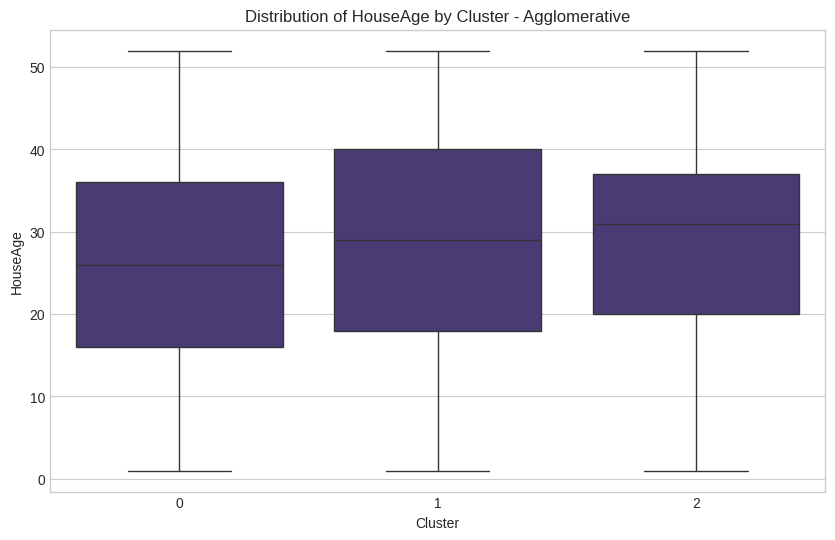

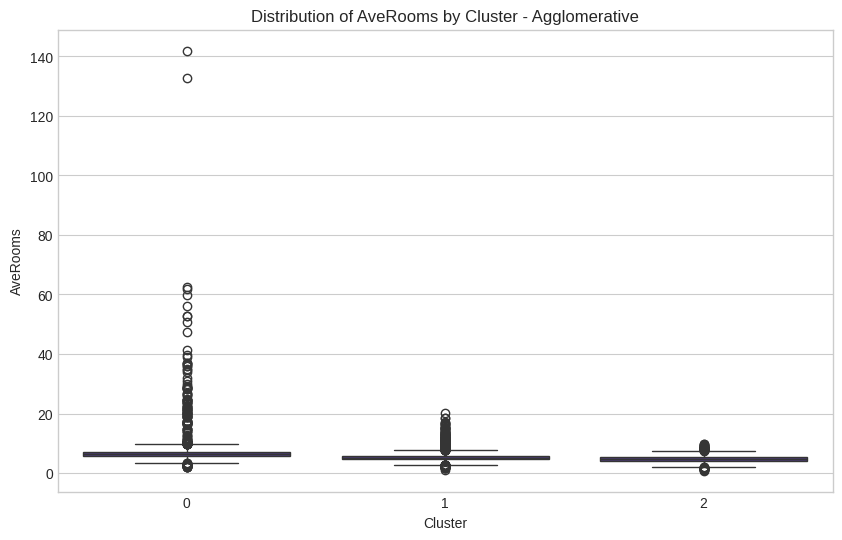

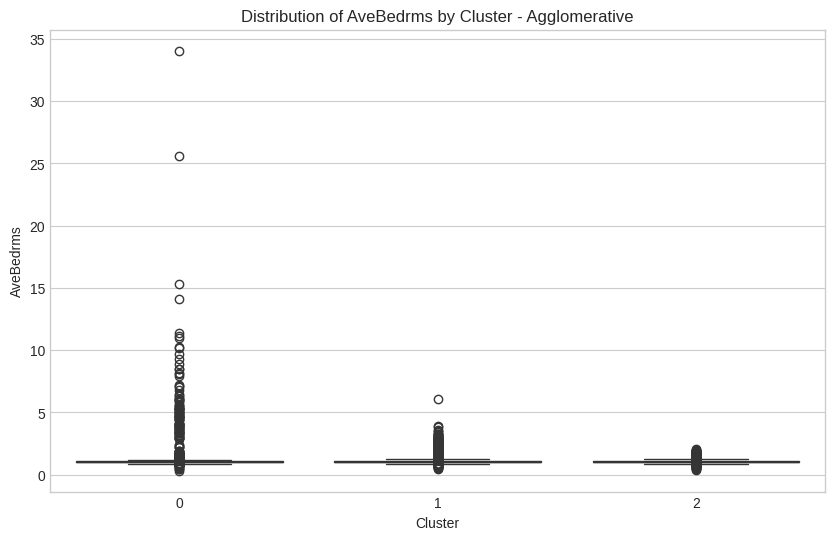

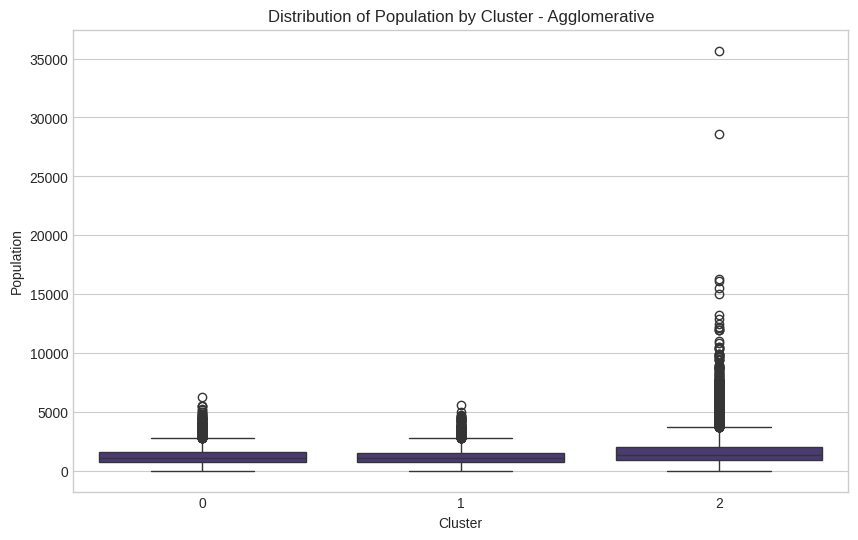

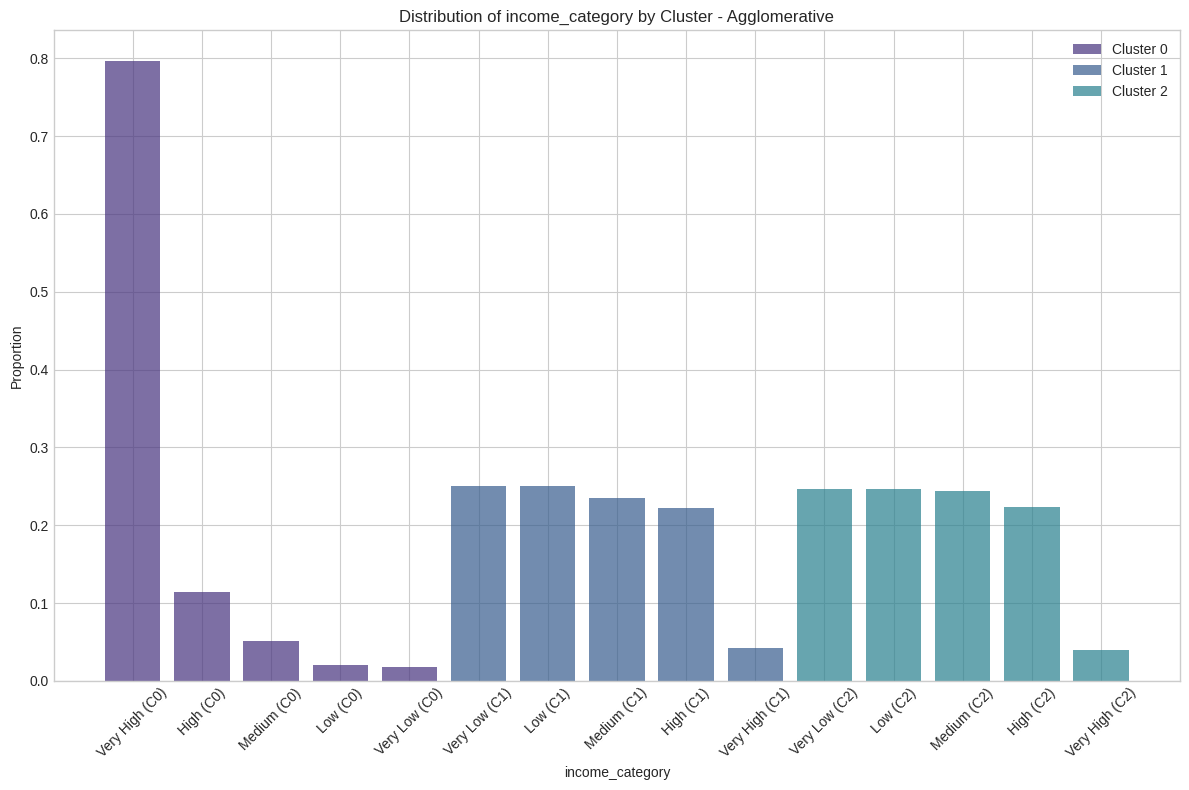

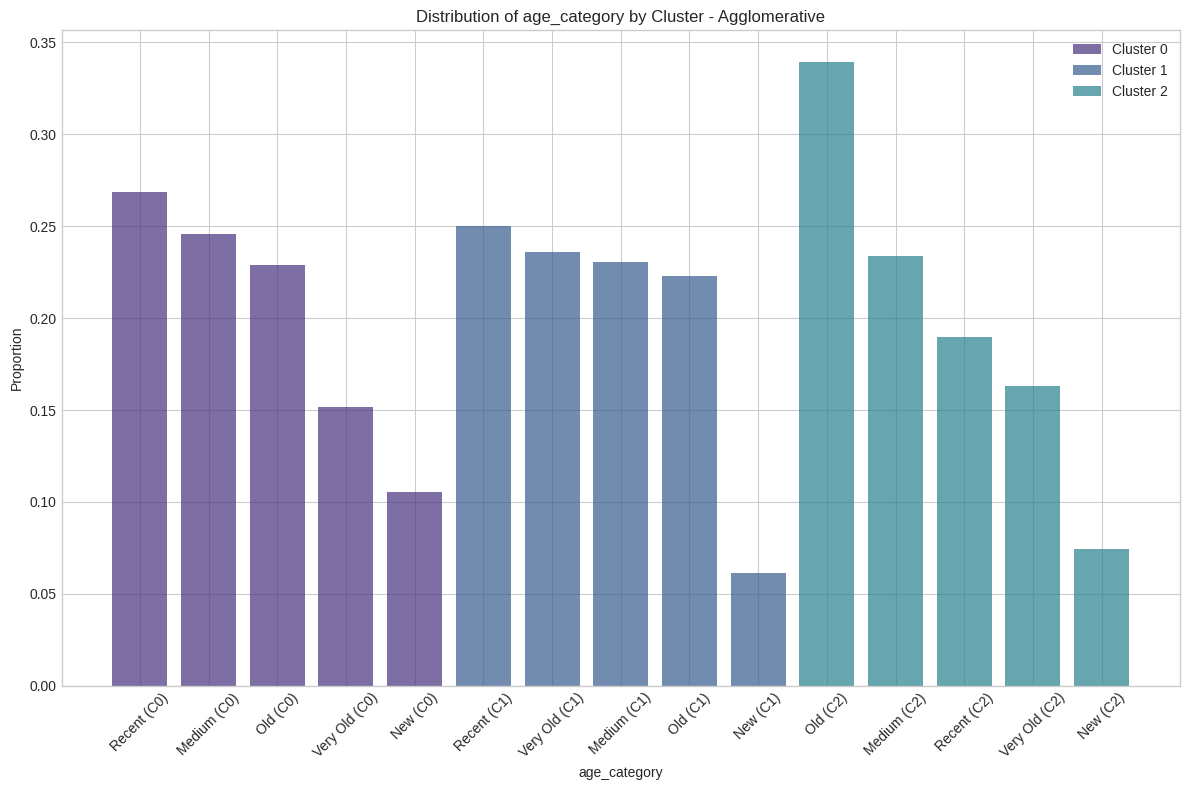

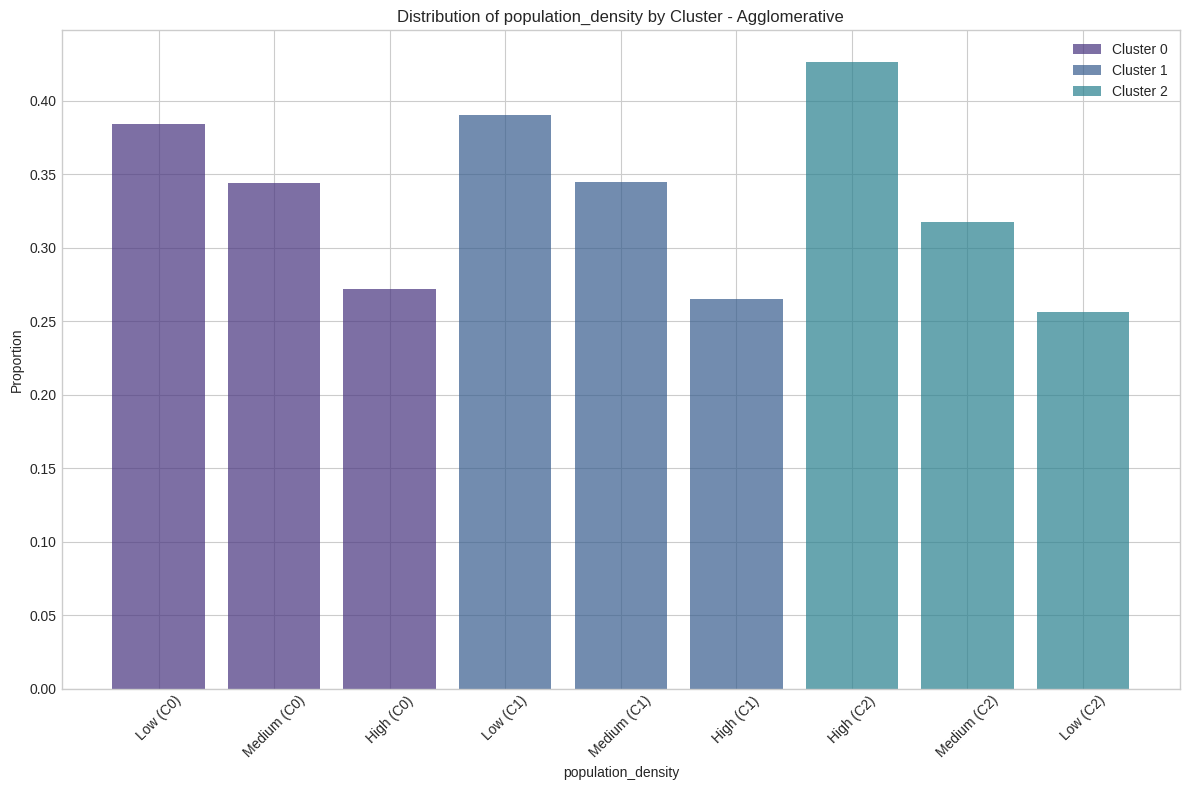

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Task 2: Unsupervised Learning (Clustering)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def load_preprocessed_data():
    """
    Load the preprocessed data from Task 1

    Returns:
        pandas.DataFrame: The preprocessed dataset
    """
    print("Loading preprocessed data...")
    try:
        df_preprocessed = pd.read_csv('california_housing_preprocessed.csv')
        print(f"Preprocessed data loaded with shape: {df_preprocessed.shape}")
        return df_preprocessed
    except FileNotFoundError:
        print("Preprocessed data file not found. Please run Task 1 first.")
        return None

def determine_optimal_clusters(data):
    """
    Determine the optimal number of clusters using the elbow method and silhouette score

    Args:
        data (numpy.ndarray): The data to cluster

    Returns:
        int: The optimal number of clusters
    """
    print("\n--- Determining Optimal Number of Clusters ---")

    # Calculate inertia (within-cluster sum of squares) for different k values
    inertia = []
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        print(f"Testing k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

        # Calculate silhouette score
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")

    # Plot the elbow method
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('optimal_clusters.png')

    # Find the optimal k based on silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")

    return optimal_k

def apply_kmeans(data, n_clusters):
    """
    Apply K-Means clustering to the data

    Args:
        data (numpy.ndarray): The data to cluster
        n_clusters (int): The number of clusters

    Returns:
        numpy.ndarray: The cluster labels
    """
    print(f"\n--- Applying K-Means Clustering with {n_clusters} clusters ---")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)

    print(f"K-Means clustering completed. Cluster distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for i, (cluster, count) in enumerate(zip(unique, counts)):
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return labels, kmeans

def apply_dbscan(data):
    """
    Apply DBSCAN clustering to the data

    Args:
        data (numpy.ndarray): The data to cluster

    Returns:
        numpy.ndarray: The cluster labels
    """
    print("\n--- Applying DBSCAN Clustering ---")

    # Determine eps using nearest neighbors
    from sklearn.neighbors import NearestNeighbors

    # Find optimal eps using k-distance graph
    neighbors = NearestNeighbors(n_neighbors=10)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    # Sort distances for k-distance graph
    distances = np.sort(distances[:, -1])

    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel('Distance')
    plt.title('K-Distance Graph (k=10)')
    plt.grid(True)
    plt.savefig('dbscan_kdistance.png')

    # Choose eps based on the "elbow" in the k-distance graph
    # For this example, we'll use a heuristic approach
    eps = np.percentile(distances, 90) * 0.5
    min_samples = 10

    print(f"Selected DBSCAN parameters: eps={eps:.4f}, min_samples={min_samples}")

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    # Count number of clusters (excluding noise points with label -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"DBSCAN clustering completed. Found {n_clusters} clusters and {n_noise} noise points.")
    print(f"Cluster distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for i, (cluster, count) in enumerate(zip(unique, counts)):
        if cluster == -1:
            print(f"Noise: {count} samples ({count/len(labels)*100:.2f}%)")
        else:
            print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return labels, dbscan

def apply_agglomerative(data, n_clusters):
    """
    Apply Agglomerative Clustering to the data

    Args:
        data (numpy.ndarray): The data to cluster
        n_clusters (int): The number of clusters

    Returns:
        numpy.ndarray: The cluster labels
    """
    print(f"\n--- Applying Agglomerative Clustering with {n_clusters} clusters ---")

    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = agg_clustering.fit_predict(data)

    print(f"Agglomerative clustering completed. Cluster distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for i, (cluster, count) in enumerate(zip(unique, counts)):
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return labels, agg_clustering

def visualize_clusters_pca(data, labels, algorithm_name):
    """
    Visualize clusters using PCA

    Args:
        data (numpy.ndarray): The data to visualize
        labels (numpy.ndarray): The cluster labels
        algorithm_name (str): The name of the clustering algorithm
    """
    print(f"\n--- Visualizing {algorithm_name} Clusters using PCA ---")

    # Apply PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Plot the clusters
    plt.figure(figsize=(10, 8))

    # Create a scatter plot
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis',
                         alpha=0.6, s=50, edgecolors='w', linewidths=0.5)

    # Add a colorbar
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title(f'Cluster Visualization using PCA - {algorithm_name}')
    plt.grid(True, alpha=0.3)

    plt.savefig(f'{algorithm_name.lower()}_pca_clusters.png')

    return reduced_data, pca

def visualize_clusters_tsne(data, labels, algorithm_name):
    """
    Visualize clusters using t-SNE

    Args:
        data (numpy.ndarray): The data to visualize
        labels (numpy.ndarray): The cluster labels
        algorithm_name (str): The name of the clustering algorithm
    """
    print(f"\n--- Visualizing {algorithm_name} Clusters using t-SNE ---")

    # Apply t-SNE to reduce dimensions to 2
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_data = tsne.fit_transform(data)

    # Plot the clusters
    plt.figure(figsize=(10, 8))

    # Create a scatter plot
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis',
                         alpha=0.6, s=50, edgecolors='w', linewidths=0.5)

    # Add a colorbar
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f'Cluster Visualization using t-SNE - {algorithm_name}')
    plt.grid(True, alpha=0.3)

    plt.savefig(f'{algorithm_name.lower()}_tsne_clusters.png')

    return reduced_data

def characterize_clusters(df_original, labels, algorithm_name):
    """
    Characterize clusters by profiling feature distributions per cluster

    Args:
        df_original (pandas.DataFrame): The original dataset
        labels (numpy.ndarray): The cluster labels
        algorithm_name (str): The name of the clustering algorithm
    """
    print(f"\n--- Characterizing {algorithm_name} Clusters ---")

    # Add cluster labels to the original dataframe
    df_with_clusters = df_original.copy()
    df_with_clusters['Cluster'] = labels

    # Select only numerical columns for mean calculation
    numerical_cols = df_original.select_dtypes(include=np.number).columns.tolist()
    df_numerical = df_with_clusters[numerical_cols + ['Cluster']]

    # For each cluster, calculate the mean of each numerical feature
    cluster_means = df_numerical.groupby('Cluster').mean()
    print("\nCluster Means:")
    print(cluster_means)

    # Create a heatmap of cluster means
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Feature Means by Cluster - {algorithm_name}')
    plt.savefig(f'{algorithm_name.lower()}_cluster_means.png')

    # For numerical features, create box plots to compare distributions across clusters
    for col in numerical_cols[:5]:  # Limit to first 5 numerical columns for brevity
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster', y=col, data=df_with_clusters)
        plt.title(f'Distribution of {col} by Cluster - {algorithm_name}')
        plt.savefig(f'{algorithm_name.lower()}_cluster_{col}_boxplot.png')

    # For categorical features, create count plots to show distribution across clusters
    categorical_cols = df_original.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in categorical_cols:
        plt.figure(figsize=(12, 8))
        for cluster in sorted(df_with_clusters['Cluster'].unique()):
            cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
            counts = cluster_data[col].value_counts(normalize=True)
            plt.bar([f"{x} (C{cluster})" for x in counts.index], counts.values,
                   label=f'Cluster {cluster}', alpha=0.7)
        plt.title(f'Distribution of {col} by Cluster - {algorithm_name}')
        plt.xlabel(col)
        plt.ylabel('Proportion')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{algorithm_name.lower()}_cluster_{col}_countplot.png')

    return df_with_clusters, cluster_means


def main():
    """
    Main function to execute Task 2
    """
    # Load the preprocessed data
    df_preprocessed = load_preprocessed_data()
    if df_preprocessed is None:
        return

    # Load the original cleaned data for later analysis
    try:
        df_cleaned = pd.read_csv('california_housing_cleaned.csv')
    except FileNotFoundError:
        print("Cleaned data file not found. Please run Task 1 first.")
        return

    # Convert the preprocessed data to a numpy array
    data = df_preprocessed.values

    # Determine the optimal number of clusters
    optimal_k = determine_optimal_clusters(data)

    # Apply K-Means clustering
    kmeans_labels, kmeans_model = apply_kmeans(data, optimal_k)

    # Apply DBSCAN clustering
    dbscan_labels, dbscan_model = apply_dbscan(data)

    # Apply Agglomerative clustering
    agg_labels, agg_model = apply_agglomerative(data, optimal_k)

    # Visualize clusters using PCA
    visualize_clusters_pca(data, kmeans_labels, 'K-Means')
    visualize_clusters_pca(data, dbscan_labels, 'DBSCAN')
    visualize_clusters_pca(data, agg_labels, 'Agglomerative')

    # Visualize clusters using t-SNE
    visualize_clusters_tsne(data, kmeans_labels, 'K-Means')
    visualize_clusters_tsne(data, dbscan_labels, 'DBSCAN')
    visualize_clusters_tsne(data, agg_labels, 'Agglomerative')

    # Characterize clusters
    kmeans_report = characterize_clusters(df_cleaned, kmeans_labels, 'K-Means')
    dbscan_report = characterize_clusters(df_cleaned, dbscan_labels, 'DBSCAN')
    agg_report = characterize_clusters(df_cleaned, agg_labels, 'Agglomerative')

    print("\nTask 2 completed.")

if __name__ == "__main__":
    main()


Task 3

Loading cleaned data...
Cleaned data loaded with shape: (20640, 12)

--- Preparing Data for Supervised Learning ---

Detected missing values in the dataset:
MedInc         988
HouseAge      1037
AveRooms      1039
AveBedrms     1029
Population    1042
dtype: int64

Handling missing values...
  - Imputed MedInc with median value: 3.5372
  - Imputed HouseAge with median value: 29.0000
  - Imputed AveRooms with median value: 5.2279
  - Imputed AveBedrms with median value: 1.0488
  - Imputed Population with median value: 1166.0000

Features shape: (20640, 18)
Target shape: (20640,)

--- Splitting Data ---
Training set: 12384 samples
Validation set: 4128 samples
Test set: 4128 samples

--- Training Baseline Linear Regression Model ---
Training RMSE: 0.7266
Training R²: 0.6014
Validation RMSE: 0.7326
Validation R²: 0.6091

--- Training Ridge Regression Model ---
Best hyperparameters: {'model__alpha': 100.0}
Training RMSE: 0.7276
Training R²: 0.6004
Validation RMSE: 0.7332
Validation R²: 0.60

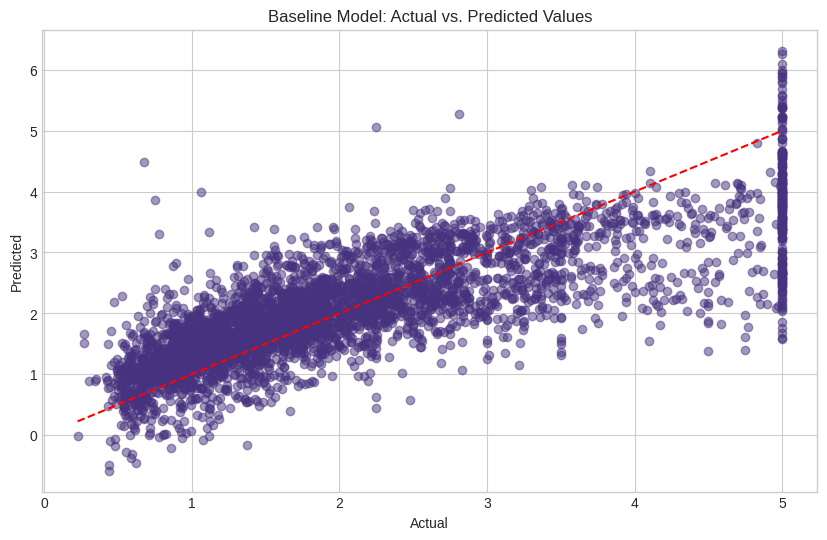

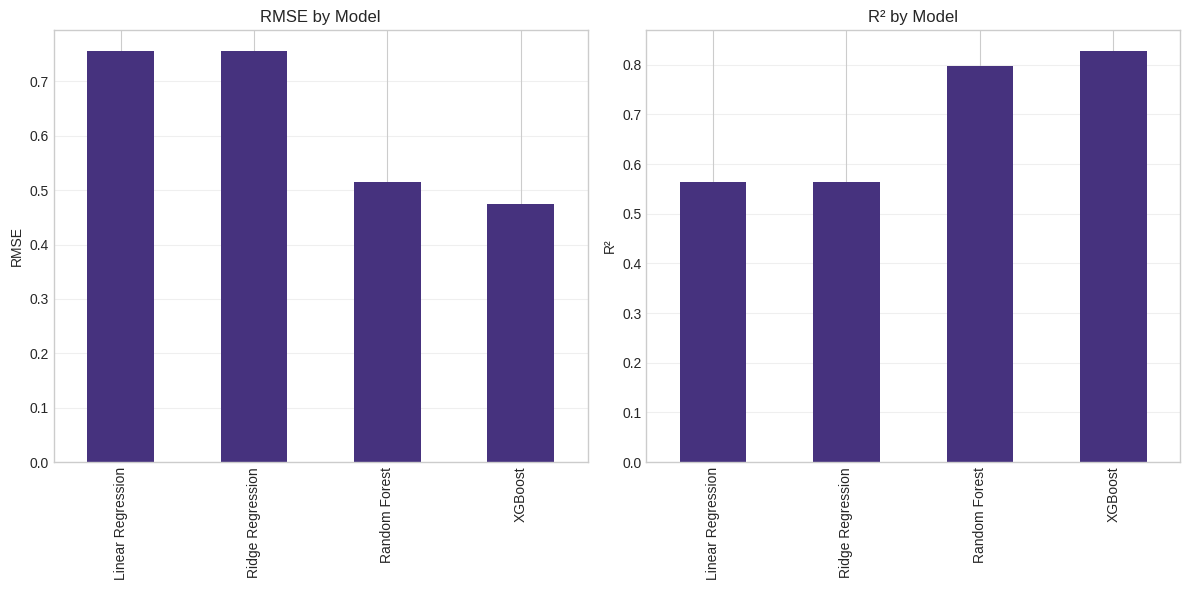

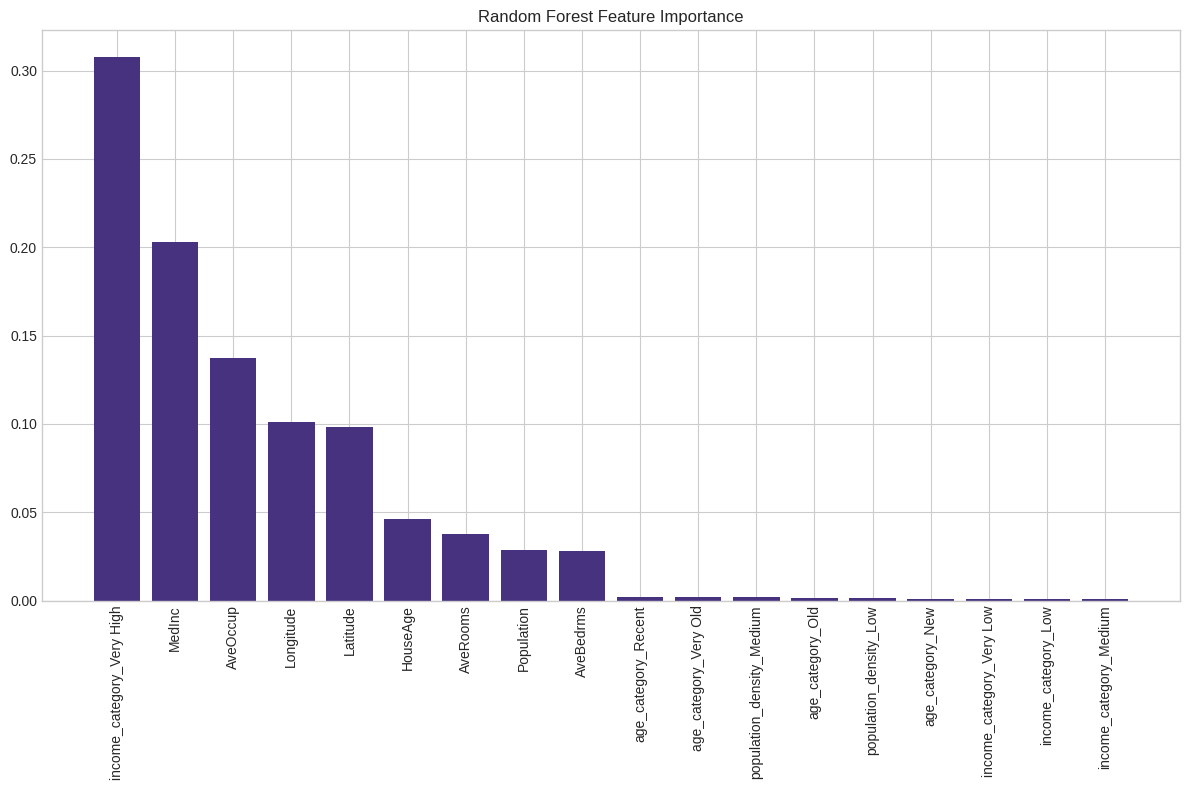

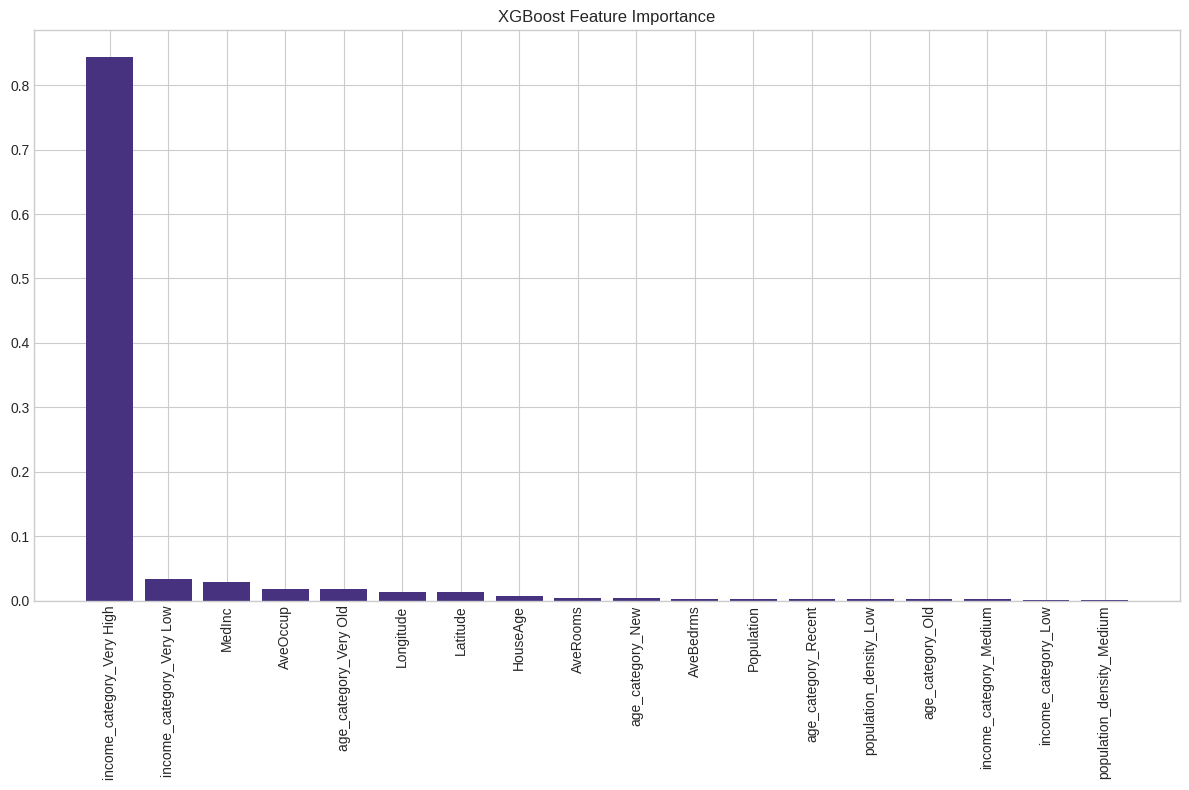

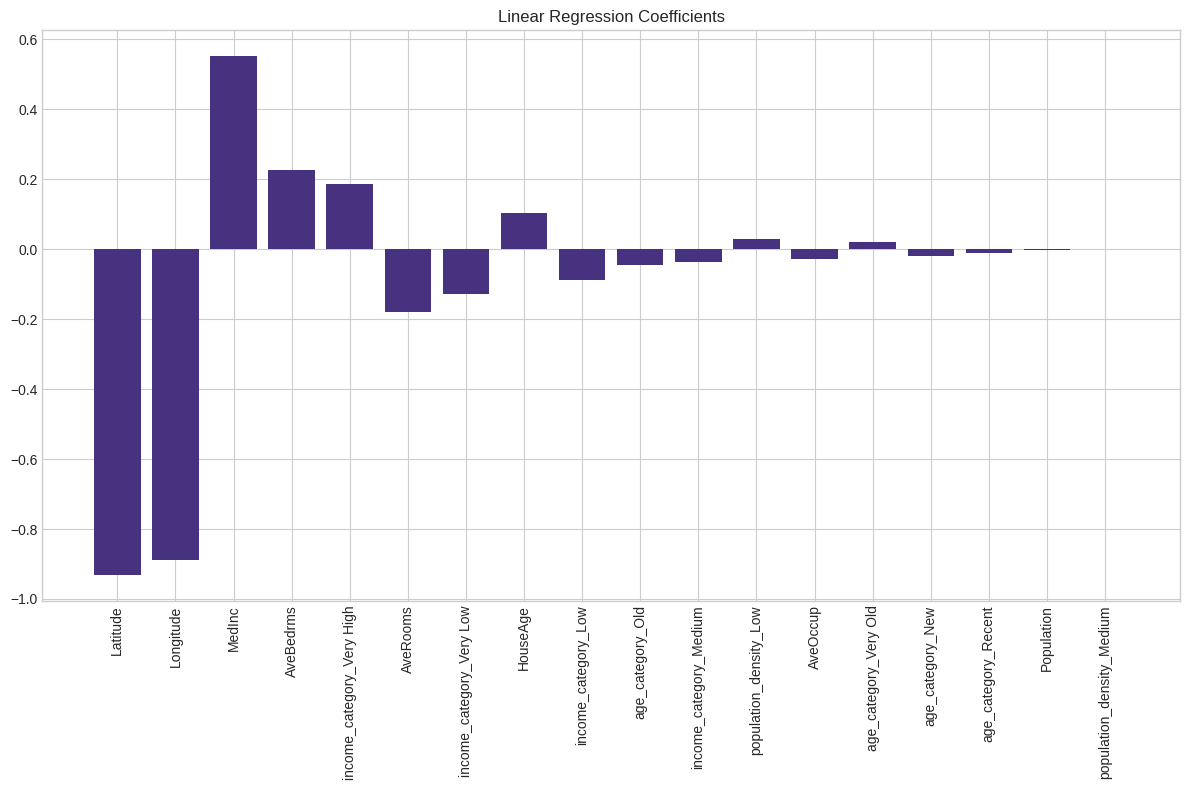

In [5]:

"""
Task 3: Supervised Learning (Regression or Classification)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def load_cleaned_data():
    """
    Load the cleaned data from Task 1

    Returns:
        pandas.DataFrame: The cleaned dataset
    """
    print("Loading cleaned data...")
    try:
        df_cleaned = pd.read_csv('california_housing_cleaned.csv')
        print(f"Cleaned data loaded with shape: {df_cleaned.shape}")
        return df_cleaned
    except FileNotFoundError:
        print("Cleaned data file not found. Please run Task 1 first.")
        return None

def prepare_data_for_supervised_learning(df):
    """
    Prepare the data for supervised learning

    Args:
        df (pandas.DataFrame): The cleaned dataset

    Returns:
        tuple: X (features), y (target), feature_names
    """
    print("\n--- Preparing Data for Supervised Learning ---")

    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nDetected missing values in the dataset:")
        print(missing_values[missing_values > 0])

        # Handle missing values
        print("\nHandling missing values...")
        # For numerical columns, use median imputation
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
        for col in numerical_cols:
            if df[col].isnull().sum() > 0:
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                print(f"  - Imputed {col} with median value: {median_val:.4f}")

        # For categorical columns, use most frequent value
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"  - Imputed {col} with mode value: {mode_val}")

    # Define the target variable (median house value)
    y = df['MedHouseVal'].values

    # Define the features (all columns except the target)
    X = df.drop('MedHouseVal', axis=1)

    # Handle categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Store feature names for later use
    feature_names = X.columns.tolist()

    # Final check for any remaining NaN values
    if X.isnull().sum().sum() > 0:
        print("\nWarning: There are still NaN values in the features. Applying additional imputation.")
        # Simple imputation for any remaining NaNs
        X = X.fillna(X.mean())

    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    return X, y, feature_names

def split_data(X, y):
    """
    Split the data into train, validation, and test sets

    Args:
        X (pandas.DataFrame): The features
        y (numpy.ndarray): The target

    Returns:
        tuple: X_train, X_val, X_test, y_train, y_val, y_test
    """
    print("\n--- Splitting Data ---")

    # First split: 80% train+val, 20% test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Second split: 75% train, 25% val (60% and 20% of the original data)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

def train_baseline_model(X_train, y_train, X_val, y_val):
    """
    Train a baseline linear regression model

    Args:
        X_train (pandas.DataFrame): The training features
        y_train (numpy.ndarray): The training target
        X_val (pandas.DataFrame): The validation features
        y_val (numpy.ndarray): The validation target

    Returns:
        sklearn.linear_model.LinearRegression: The trained model
    """
    print("\n--- Training Baseline Linear Regression Model ---")

    # Create a pipeline with scaling and linear regression
    baseline_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])

    # Train the model
    baseline_pipeline.fit(X_train, y_train)

    # Evaluate on training set
    y_train_pred = baseline_pipeline.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")

    # Evaluate on validation set
    y_val_pred = baseline_pipeline.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Baseline Model: Actual vs. Predicted Values')
    plt.savefig('baseline_actual_vs_predicted.png')

    return baseline_pipeline, val_rmse, val_r2

def train_ridge_regression(X_train, y_train, X_val, y_val):
    """
    Train a Ridge regression model with hyperparameter tuning

    Args:
        X_train (pandas.DataFrame): The training features
        y_train (numpy.ndarray): The training target
        X_val (pandas.DataFrame): The validation features
        y_val (numpy.ndarray): The validation target

    Returns:
        sklearn.pipeline.Pipeline: The trained model
    """
    print("\n--- Training Ridge Regression Model ---")

    # Create a pipeline with scaling and Ridge regression
    ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ])

    # Define hyperparameter grid
    param_grid = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_ridge = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best hyperparameters: {best_params}")

    # Evaluate on training set
    y_train_pred = best_ridge.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")

    # Evaluate on validation set
    y_val_pred = best_ridge.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    return best_ridge, val_rmse, val_r2

def train_random_forest(X_train, y_train, X_val, y_val):
    """
    Train a Random Forest regression model with hyperparameter tuning

    Args:
        X_train (pandas.DataFrame): The training features
        y_train (numpy.ndarray): The training target
        X_val (pandas.DataFrame): The validation features
        y_val (numpy.ndarray): The validation target

    Returns:
        sklearn.pipeline.Pipeline: The trained model
    """
    print("\n--- Training Random Forest Regression Model ---")

    # Create a pipeline with Random Forest regression
    rf_pipeline = Pipeline([
        ('model', RandomForestRegressor(random_state=42))
    ])

    # Define hyperparameter grid
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        rf_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_rf = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best hyperparameters: {best_params}")

    # Evaluate on training set
    y_train_pred = best_rf.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")

    # Evaluate on validation set
    y_val_pred = best_rf.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    return best_rf, val_rmse, val_r2

def train_xgboost(X_train, y_train, X_val, y_val):
    """
    Train an XGBoost regression model with hyperparameter tuning

    Args:
        X_train (pandas.DataFrame): The training features
        y_train (numpy.ndarray): The training target
        X_val (pandas.DataFrame): The validation features
        y_val (numpy.ndarray): The validation target

    Returns:
        sklearn.pipeline.Pipeline: The trained model
    """
    print("\n--- Training XGBoost Regression Model ---")

    # Create a pipeline with XGBoost regression
    xgb_pipeline = Pipeline([
        ('model', XGBRegressor.XGBRegressor(random_state=42))
    ])

    # Define hyperparameter grid
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 6, 9],
        'model__learning_rate': [0.01, 0.1, 0.3]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        xgb_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_xgb = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best hyperparameters: {best_params}")

    # Evaluate on training set
    y_train_pred = best_xgb.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")

    # Evaluate on validation set
    y_val_pred = best_xgb.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    return best_xgb, val_rmse, val_r2

def evaluate_on_test_set(models, X_test, y_test):
    """
    Evaluate all models on the test set

    Args:
        models (dict): Dictionary of trained models
        X_test (pandas.DataFrame): The test features
        y_test (numpy.ndarray): The test target
    """
    print("\n--- Evaluating Models on Test Set ---")

    results = {}

    for name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }

        print(f"\n{name} Test Results:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R²: {r2:.4f}")

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        model_name: {
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'R²': metrics['R²']
        } for model_name, metrics in results.items()
    }).T

    # Plot the results
    plt.figure(figsize=(12, 6))

    # Plot RMSE
    plt.subplot(1, 2, 1)
    results_df['RMSE'].plot(kind='bar')
    plt.title('RMSE by Model')
    plt.ylabel('RMSE')
    plt.grid(axis='y', alpha=0.3)

    # Plot R²
    plt.subplot(1, 2, 2)
    results_df['R²'].plot(kind='bar')
    plt.title('R² by Model')
    plt.ylabel('R²')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_comparison.png')

    # Save the results to a CSV file
    results_df.to_csv('model_results.csv')

    return results_df

def plot_feature_importance(models, feature_names):
    """
    Plot feature importance for applicable models

    Args:
        models (dict): Dictionary of trained models
        feature_names (list): List of feature names
    """
    print("\n--- Plotting Feature Importance ---")

    # For Random Forest
    if 'Random Forest' in models:
        rf_model = models['Random Forest'].named_steps['model']

        # Get feature importance
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.title('Random Forest Feature Importance')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('rf_feature_importance.png')

        # Print top 10 features
        print("\nTop 10 features by importance (Random Forest):")
        for i in range(10):
            print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    # For XGBoost
    if 'XGBoost' in models:
        xgb_model = models['XGBoost'].named_steps['model']

        # Get feature importance
        importances = xgb_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.title('XGBoost Feature Importance')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('xgb_feature_importance.png')

        # Print top 10 features
        print("\nTop 10 features by importance (XGBoost):")
        for i in range(10):
            print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    # For Linear models (coefficients)
    if 'Linear Regression' in models:
        lr_model = models['Linear Regression'].named_steps['model']
        scaler = models['Linear Regression'].named_steps['scaler']

        # Get coefficients
        coefficients = lr_model.coef_
        indices = np.argsort(np.abs(coefficients))[::-1]

        # Plot coefficients
        plt.figure(figsize=(12, 8))
        plt.title('Linear Regression Coefficients')
        plt.bar(range(len(coefficients)), coefficients[indices], align='center')
        plt.xticks(range(len(coefficients)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('lr_coefficients.png')

        # Print top 10 features
        print("\nTop 10 features by coefficient magnitude (Linear Regression):")
        for i in range(10):
            print(f"{feature_names[indices[i]]}: {coefficients[indices[i]]:.4f}")

def main():
    """
    Main function to execute Task 3
    """
    # Load the cleaned data
    df_cleaned = load_cleaned_data()
    if df_cleaned is None:
        return

    # Prepare data for supervised learning
    X, y, feature_names = prepare_data_for_supervised_learning(df_cleaned)

    # Split the data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Train baseline model
    baseline_model, baseline_val_rmse, baseline_val_r2 = train_baseline_model(X_train, y_train, X_val, y_val)

    # Train Ridge regression model
    ridge_model, ridge_val_rmse, ridge_val_r2 = train_ridge_regression(X_train, y_train, X_val, y_val)

    # Train Random Forest model
    rf_model, rf_val_rmse, rf_val_r2 = train_random_forest(X_train, y_train, X_val, y_val)

    # Train XGBoost model
    xgb_model, xgb_val_rmse, xgb_val_r2 = train_xgboost(X_train, y_train, X_val, y_val)

    # Collect all models
    models = {
        'Linear Regression': baseline_model,
        'Ridge Regression': ridge_model,
        'Random Forest': rf_model,
        'XGBoost': xgb_model
    }

    # Evaluate on test set
    test_results = evaluate_on_test_set(models, X_test, y_test)

    # Plot feature importance
    plot_feature_importance(models, feature_names)

    # Save the best model
    best_model_name = test_results['R²'].idxmax()
    best_model = models[best_model_name]
    joblib.dump(best_model, 'best_model.pkl')

    print(f"\nBest model ({best_model_name}) saved to 'best_model.pkl'")
    print("\nTask 3 completed.")

if __name__ == "__main__":
    main()


In [ ]:
import zipfile
import os

def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Example usage:
zip_folder('/content/', 'tasks.zip')


In [8]:
import os

def get_folder_size(folder_path):
    """Return total size of folder in bytes."""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            if os.path.exists(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

def list_items_in_mb(folder_path):
    """List all files and subfolders with size in MB."""
    items = os.listdir(folder_path)
    for item in items:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            size_mb = os.path.getsize(item_path) / (1024 * 1024)
        else:
            size_mb = get_folder_size(item_path) / (1024 * 1024)
        print(f"{item}: {size_mb:.2f} MB")

# Example usage:
list_items_in_mb('/content/')


.config: 0.08 MB
dbscan_cluster_means.png: 0.47 MB
dbscan_cluster_population_density_countplot.png: 0.18 MB
k-means_cluster_age_category_countplot.png: 0.04 MB
k-means_cluster_HouseAge_boxplot.png: 0.02 MB
.ipynb_checkpoints: 0.00 MB
agglomerative_cluster_age_category_countplot.png: 0.05 MB
age_vs_house_value.png: 0.02 MB
california_housing_cleaned.csv: 2.13 MB
lr_coefficients.png: 0.05 MB
dbscan_kdistance.png: 0.02 MB
dbscan_cluster_income_category_countplot.png: 0.21 MB
rf_feature_importance.png: 0.05 MB
dbscan_cluster_MedInc_boxplot.png: 0.06 MB
agglomerative_pca_clusters.png: 0.12 MB
k-means_cluster_MedInc_boxplot.png: 0.02 MB
k-means_pca_clusters.png: 0.12 MB
k-means_tsne_clusters.png: 0.35 MB
dbscan_cluster_HouseAge_boxplot.png: 0.06 MB
agglomerative_cluster_population_density_countplot.png: 0.04 MB
k-means_cluster_Population_boxplot.png: 0.03 MB
dbscan_cluster_AveBedrms_boxplot.png: 0.05 MB
agglomerative_cluster_AveBedrms_boxplot.png: 0.02 MB
income_vs_house_value.png: 0.36 MB
d

In [9]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            if os.path.exists(file_path):  # check if file still exists
                total_size += os.path.getsize(file_path)
    return total_size  # size in bytes

folder_path = '/content/'
size_bytes = get_folder_size(folder_path)
print(f"Folder size: {size_bytes / (1024 * 1024):.2f} MB")  # Convert to MB


Folder size: 65.03 MB
